The validation scheme is based on [seq2seq-rnn-with-gru](https://www.kaggle.com/brandenkmurray/seq2seq-rnn-with-gru/output), and cleaned data is from [data-without-drift](https://www.kaggle.com/cdeotte/data-without-drift) and Kalman filter is from [https://www.kaggle.com/teejmahal20/single-model-lgbm-kalman-filter](single-model-lgbm-kalman-filter) and the added feature is from [wavenet-with-1-more-feature](wavenet-with-1-more-feature). I also used ragnar's data in this version [clean-kalman](https://www.kaggle.com/ragnar123/clean-kalman). The Wavenet is based on [https://github.com/philipperemy/keras-tcn](https://github.com/philipperemy/keras-tcn), [https://github.com/peustr/wavenet](https://github.com/peustr/wavenet) and [https://github.com/basveeling/wavenet](https://github.com/basveeling/wavenet) and also [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm). If any refrence is not mentioned it was not intentional, please add them in comments.

Previous versions were mainly based on [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm)  

In [0]:
!pip install --no-warn-conflicts -q tensorflow-addons

In [0]:
from tensorflow.keras.layers import (TimeDistributed, Dropout, BatchNormalization, Flatten, Convolution1D, Activation, Input, Dense, LSTM, Lambda, Bidirectional,
                                     Add, AveragePooling1D, Multiply, GRU, GRUCell, LSTMCell, SimpleRNNCell, SimpleRNN, TimeDistributed, RNN,SpatialDropout1D,
                                     RepeatVector, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Concatenate, GlobalAveragePooling1D, UpSampling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error
# from tensorflow.keras.experimental import export_saved_model, load_from_saved_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.python.ops import array_ops
import tensorflow as tf
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.metrics import f1_score, cohen_kappa_score, mean_squared_error
from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO, DEBUG, NOTSET
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import display
from sklearn import preprocessing
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import scipy.stats as stats
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import time
import pywt
import os
import gc
import numpy.fft as fft
from scipy import signal as scisig
from sklearn.linear_model import LinearRegression

from tensorflow.keras.metrics import Precision, Recall
# from tensorflow_addons.metrics import F1Score

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [0]:
Kaggle = False
Colab = True

In [4]:
import os, sys
from pathlib import Path

if Colab:
    from google.colab import drive
    drive.mount('/content/drive')

    path = "/content/drive/My Drive"

    os.chdir(path)
    os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# sys.path.append('ion_switch/keras-one-cycle')
# # os.listdir(patholr)
# from clr import OneCycleLR

In [0]:
if Kaggle:
    PATH = '/kaggle/input/'
    outdir = '.'
# PATH = '/Users/helen/Desktop/Data/'
else:
    PATH = 'ion_switch/'
    outdir = Path(PATH+'res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = Path(PATH+'res/wavenet-dlr-res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)

In [0]:
EPOCHS=180
NNBATCHSIZE= 16
BATCHSIZE = 4000
SEED = 321
SELECT = True
SPLITS = 5
LR = 0.001
WD = 1e-5
Gamma = 1.0 #0.99994
BETA = 0.99996
fe_config = [
    (True, BATCHSIZE),
]
TREES = 100
DEPTH = 12
# TREES = 20
# DEPTH = 10
COMPETITION = 'ION-Switching'
logger = getLogger(COMPETITION)
LOGFORMAT = '%(asctime)s %(levelname)s %(message)s'
MODELNAME = 'WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL'
weights = []
TRAINEDMODEL = os.path.join(outdir, 'wavenet-es-v1/wavenet_es_f0_checkpoint.h5')

VERSION = '{}_len{}_bs{}_lr{}_tn{}_dn{}'.format(MODELNAME, BATCHSIZE, NNBATCHSIZE, LR, TREES, DEPTH)
outdir = os.path.join(outdir, VERSION)
if not os.path.exists(outdir):
    os.mkdir(outdir)

from datetime import datetime
dateTimeObj = datetime.now()
# timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H")
timestampStr = 'all-v8-4'
outdir = os.path.join(outdir, timestampStr)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [0]:

@contextmanager
def timer(name : Text):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')

In [0]:

def init_logger():

    handler = StreamHandler()
    handler.setLevel(INFO)
    handler.setFormatter(Formatter(LOGFORMAT))
    fh_handler = FileHandler(os.path.join(outdir,'{}-len{}-lr{}-{}.log'.format(MODELNAME,BATCHSIZE,LR,timestampStr)))
    fh_handler.setFormatter(Formatter(LOGFORMAT))
    logger.setLevel(INFO)
    logger.addHandler(handler)
    logger.addHandler(fh_handler)
    

In [0]:

def seed_everything(seed : int) -> NoReturn :
    
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    # os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed) 

seed_everything(SEED)

In [0]:
class CyclicLR(tf.keras.callbacks.Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())
        # print("learning rate- self.model.optimizer.lr: ", self.model.optimizer.lr)

    # def on_epoch_end(self, epoch, logs=None):

    #     logs = logs or {}
    #     self.trn_iterations += 1
    #     self.clr_iterations += 1

    #     K.set_value(self.model.optimizer.lr, self.clr())
    #     logger.info(f'epoch:{epoch:03d},'+str(K.eval(self.model.optimizer.lr)))

In [0]:
import matplotlib.pyplot as plt

# 写一个LossHistory类，保存训练集的loss和acc
# 当然我也可以完全不这么做，可以直接使用model.fit()方法返回的 history对象去做
'''Callback有6个常用的方法，这里实现其中的四个
    def on_epoch_begin(self, epoch, logs=None):
    def on_epoch_end(self, epoch, logs=None):
    def on_batch_begin(self, batch, logs=None):
    def on_batch_end(self, batch, logs=None):
    def on_train_begin(self, logs=None):
    def on_train_end(self, logs=None):
'''
class LossHistory(Callback):  # 继承自Callback类
 
    '''
    在模型开始的时候定义四个属性，每一个属性都是字典类型，存储相对应的值和epoch
    '''
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    # 在每一个batch结束后记录相应的值
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
    
    # 在每一个epoch之后记录相应的值
    def on_epoch_end(self, epoch, logs={}):
        trloss, tracc, vloss, vacc = logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')
        self.losses['epoch'].append(trloss)
        self.accuracy['epoch'].append(tracc)
        self.val_loss['epoch'].append(vloss)
        self.val_acc['epoch'].append(vacc)
        logger.info("epoch:{:03d}, train_loss:{:1.5f}, train_acc:{:1.5f}, val_loss:{:1.5f}, val_acc:{:1.5f}".format(epoch, 
                                                                                                                trloss, tracc, vloss, vacc))
 
    def loss_plot(self, loss_type, pngname):
        '''
        loss_type：指的是 'epoch'或者是'batch'，分别表示是一个batch之后记录还是一个epoch之后记录
        '''
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig(pngname)
        plt.show()

In [0]:

def read_data(base : os.path.abspath) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    train = pd.read_csv(PATH+'clean-kalman/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv(PATH+'clean-kalman/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(PATH+'liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    test_label = pd.read_csv(PATH+'WaveNetAug-ConvGRUtfProb11-NESCAL-ft_pred.csv', dtype={'time': np.float32, 'open_channels':np.int32})
    return train, test, sub, test_label


In [0]:

def batching(df : pd.DataFrame,
             batch_size : int) -> pd.DataFrame :
    
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
        
    return df


In [0]:

def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df


In [0]:

def lag_with_pct_change(df : pd.DataFrame,
                        shift_sizes : Optional[List]=[1, 2],
                        add_pct_change : Optional[bool]=False,
                        add_pct_change_lag : Optional[bool]=False,
                        add_diff : Optional[bool]=False) -> pd.DataFrame:
    
    for shift_size in shift_sizes:    
        df['signal_shift_pos_'+str(shift_size)] = df.groupby('group')['signal'].shift(shift_size).fillna(0)
        df['signal_shift_neg_'+str(shift_size)] = df.groupby('group')['signal'].shift(-1*shift_size).fillna(0)

    if add_pct_change:
        df['pct_change'] = df['signal'].pct_change()
        if add_pct_change_lag:
            for shift_size in shift_sizes:    
                df['pct_change_shift_pos_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(shift_size).fillna(0)
                df['pct_change_shift_neg_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(-1*shift_size).fillna(0)
    if add_diff:
        for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'group', 'index']]:
            df[c+'_msignal'] = df[c] - df['signal']
    return df


In [0]:

def run_feat_enginnering(df : pd.DataFrame,
                         create_all_data_feats : bool,
                         batch_size : int) -> pd.DataFrame:
    
    df = batching(df, batch_size=batch_size)
    if create_all_data_feats:
        df = lag_with_pct_change(df, [1, 2, 3],  add_pct_change=False, add_pct_change_lag=False, add_diff=False)
    df['signal_2'] = df['signal'] ** 2
    return df


In [0]:
def feature_selection(df : pd.DataFrame,
                      df_test : pd.DataFrame) -> Tuple[pd.DataFrame , pd.DataFrame, List]:
    use_cols = [col for col in df.columns if col not in ['index','group', 'open_channels', 'time']]
    print(use_cols)
    df = df.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
    for col in use_cols:
        col_mean = pd.concat([df[col], df_test[col]], axis=0).mean()
        df[col] = df[col].fillna(col_mean)
        df_test[col] = df_test[col].fillna(col_mean)
   
    gc.collect()
    return df, df_test, use_cols


In [0]:
def jitter(x, sigma=0.03):
    # print("jitter x shape:", x.shape)
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def rotation2d(x, sigma=0.2):
    thetas = np.random.normal(loc=0, scale=sigma, size=(x.shape[0]))
    c = np.cos(thetas)
    s = np.sin(thetas)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        rot = np.array(((c[i], -s[i]), (s[i], c[i])))
        ret[i] = np.dot(pat, rot)
    return ret

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def spawner(x, labels, sigma=0.05, verbose=0):
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983028/
    
    import utils.dtw as dtw
    random_points = np.random.randint(low=1, high=x.shape[1]-1, size=x.shape[0])
    window = np.ceil(x.shape[1] / 10.).astype(int)
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:     
            random_sample = x[np.random.choice(choices)]
            # SPAWNER splits the path into two randomly
            path1 = dtw.dtw(pat[:random_points[i]], random_sample[:random_points[i]], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            path2 = dtw.dtw(pat[random_points[i]:], random_sample[random_points[i]:], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            combined = np.concatenate((np.vstack(path1), np.vstack(path2+random_points[i])), axis=1)
            if verbose:
                print(random_points[i])
                dtw_value, cost, DTW_map, path = dtw.dtw(pat, random_sample, return_flag = dtw.RETURN_ALL, slope_constraint=slope_constraint, window=window)
                dtw.draw_graph1d(cost, DTW_map, path, pat, random_sample)
                dtw.draw_graph1d(cost, DTW_map, combined, pat, random_sample)
            mean = np.mean([pat[combined[0]], random_sample[combined[1]]], axis=0)
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=mean.shape[0]), mean[:,dim]).T
        else:
            print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = pat
    return jitter(ret, sigma=sigma)

def wdba(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True):
    # https://ieeexplore.ieee.org/document/8215569
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
        
    ret = np.zeros_like(x)
    for i in tqdm(range(ret.shape[0])):
        # get the same class as i
        choices = np.where(l == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            k = min(choices.size, batch_size)
            random_prototypes = x[np.random.choice(choices, k, replace=False)]
            
            # calculate dtw between all
            dtw_matrix = np.zeros((k, k))
            for p, prototype in enumerate(random_prototypes):
                for s, sample in enumerate(random_prototypes):
                    if p == s:
                        dtw_matrix[p, s] = 0.
                    else:
                        dtw_matrix[p, s] = dtw.dtw(prototype, sample, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                        
            # get medoid
            medoid_id = np.argsort(np.sum(dtw_matrix, axis=1))[0]
            nearest_order = np.argsort(dtw_matrix[medoid_id])
            medoid_pattern = random_prototypes[medoid_id]
            
            # start weighted DBA
            average_pattern = np.zeros_like(medoid_pattern)
            weighted_sums = np.zeros((medoid_pattern.shape[0]))
            for nid in nearest_order:
                if nid == medoid_id or dtw_matrix[medoid_id, nearest_order[1]] == 0.:
                    average_pattern += medoid_pattern 
                    weighted_sums += np.ones_like(weighted_sums) 
                else:
                    path = dtw.dtw(medoid_pattern, random_prototypes[nid], dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                    dtw_value = dtw_matrix[medoid_id, nid]
                    warped = random_prototypes[nid, path[1]]
                    weight = np.exp(np.log(0.5)*dtw_value/dtw_matrix[medoid_id, nearest_order[1]])
                    average_pattern[path[0]] += weight * warped
                    weighted_sums[path[0]] += weight 
            
            ret[i,:] = average_pattern / weighted_sums[:,np.newaxis]
        else:
            print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = x[i]
    return ret

# Proposed

def random_guided_warp(x, labels, slope_constraint="symmetric", use_window=True, dtw_type="normal"):
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            random_prototype = x[np.random.choice(choices)]
            
            if dtw_type == "shape":
                path = dtw.shape_dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                path = dtw.dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                            
            # Time warp
            warped = pat[path[1]]
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            print("There is only one pattern of class %d, skipping timewarping"%l[i])
            ret[i,:] = pat
    return ret

def discriminative_guided_warp(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True):
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    positive_batch = np.ceil(batch_size / 2).astype(int)
    negative_batch = np.floor(batch_size / 2).astype(int)
        
    ret = np.zeros_like(x)
    warp_amount = np.zeros(x.shape[0])
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        
        # remove ones of different classes
        positive = np.where(l[choices] == l[i])[0]
        negative = np.where(l[choices] != l[i])[0]
        
        if positive.size > 0 and negative.size > 0:
            pos_k = min(positive.size, positive_batch)
            neg_k = min(negative.size, negative_batch)
            positive_prototypes = x[np.random.choice(positive, pos_k, replace=False)]
            negative_prototypes = x[np.random.choice(negative, neg_k, replace=False)]
                        
            # vector embedding and nearest prototype in one
            pos_aves = np.zeros((pos_k))
            neg_aves = np.zeros((pos_k))
            if dtw_type == "shape":
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.shape_dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.shape_dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.shape_dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                   
            # Time warp
            warped = pat[path[1]]
            warp_path_interp = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), path[1])
            warp_amount[i] = np.sum(np.abs(orig_steps-warp_path_interp))
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            print("There is only one pattern of class %d"%l[i])
            ret[i,:] = pat
            warp_amount[i] = 0.
    if use_variable_slice:
        max_warp = np.max(warp_amount)
        if max_warp == 0:
            # unchanged
            ret = window_slice(ret, reduce_ratio=0.95)
        else:
            for i, pat in enumerate(ret):
                # Variable Sllicing
                ret[i] = window_slice(pat[np.newaxis,:,:], reduce_ratio=0.95+0.05*warp_amount[i]/max_warp)[0]
    return ret

In [0]:
def feature_roll_diff(x):
    for i in range(3):
      pos_x = np.roll(x[:,:,0][:,:,None], i)
      neg_x = np.roll(x[:,:,0][:,:,None], -i)
      # print("pos_x.shape", pos_x.shape)
      x =  np.concatenate((x, pos_x),axis = 2)
      x =  np.concatenate((x, neg_x),axis = 2)
      # print("x.shape 1 ", x.shape)
      x =  np.concatenate((x, pos_x - x[:,:,0][:,:,None]),axis = 2) 
      x =  np.concatenate((x, neg_x - x[:,:,0][:,:,None]),axis = 2)
      # print("x.shape 2 ", x.shape)
    x =  np.concatenate((x, x[:,:,0][:,:,None]**2),axis = 2)
      # print("x.shape 3 ", x.shape) 
    return x       

In [0]:
# @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)]) 
# def tf_feature_roll_diff(input): 
#   y = tf.numpy_function(feature_roll_diff, [input], tf.float32) 
#   return y

In [0]:

def augment(X: np.array, y:np.array) -> Tuple[np.array, np.array]:
  
    X_aug = np.flip(X, axis=1)
    X = np.vstack((X, X_aug))
    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y

In [0]:
def augment_label(X: np.array, y:np.array, Xtest : np.array, Xval : np.array) -> Tuple[np.array, np.array, np.array, np.array]:
    X_aug = np.flip(X, axis=1)
    print("X_aug shape 1:", X_aug.shape)
    X = np.concatenate((X, np.zeros_like(X[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)
    Xtest = np.concatenate((Xtest, np.zeros_like(Xtest[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)
    Xval = np.concatenate((Xval, np.zeros_like(Xval[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)   
    
    X_aug = np.concatenate((X_aug, np.ones_like(X_aug[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)

    print("X_aug shape 2:", X_aug.shape)
    X = np.vstack((X, X_aug))
    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y, Xtest, Xval

In [0]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()

In [0]:
# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:24:41.652529Z","start_time":"2020-04-03T23:24:41.645025Z"}}
# class EarlyStopping:
#     def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
#         self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
#         self.counter, self.best_score = 0, None
#         self.is_maximize = is_maximize

#     def load_best_weights(self, sess):
#         saver.restore(sess, self.checkpoint_path)

#     def __call__(self, score, sess):
#         if self.best_score is None or \
#         (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
#             saver.save(sess, self.checkpoint_path)
#             self.best_score, self.counter = score, 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class ShiftedFeatureMaker(BaseEstimator, TransformerMixin):
    
    def __init__(self, periods=[1], column="signal", add_minus=False, fill_value=None, copy=True):
        self.periods = periods
        self.column = column
        self.add_minus = add_minus
        self.fill_value = fill_value
        self.copy = copy
        
    def fit(self, X, y):
        """Mock method"""
        return self
    
    def transform(self, X: pd.DataFrame, y=None):
        periods = np.asarray(self.periods, dtype=np.int32)
        
        if self.add_minus:
            periods = np.append(periods, -periods)
        
        X_transformed = X.copy() if self.copy else X
        
        for p in periods:
            X_transformed[f"{self.column}_shifted_{p}"] = X_transformed[self.column].shift(
                periods=p, fill_value=self.fill_value
            )
            
        return X_transformed


class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y):
        """Mock method"""
        return self
    
    def transform(self, X: pd.DataFrame, y=None):
        return X[[c for c in X.columns if c not in self.columns]]


def add_category(train, test):
    train["category"] = 0
    test["category"] = 0
    
    # train segments with more then 9 open channels classes
    train.loc[2_000_000:2_500_000-1, 'category'] = 1
    train.loc[4_500_000:5_000_000-1, 'category'] = 1
    
    # # delete very noized part 
    # train.loc[3_650_000:3_820_000, "category"] = -1
    # train = train[train.category != -1].reset_index(drop=True)
    
    # test segments with more then 9 open channels classes (potentially)
    test.loc[500_000:600_000-1, "category"] = 1
    test.loc[700_000:800_000-1, "category"] = 1
    
    return train, test

def add_5_category(train, test):

    train["category"] = 0
    test["category"] = 0

    #slow open channel
    batch = 1; a = 500000*(batch-1); b = 500000*batch
    batch = 2; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 1
    train.loc[c:d, "category"] = 1 

    # fast open channel
    batch = 3; a = 500000*(batch-1); b = 500000*batch
    batch = 7; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 2
    train.loc[c:d, "category"] = 2

    # 3 channel
    batch = 4; a = 500000*(batch-1); b = 500000*batch
    batch = 8; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 3
    train.loc[c:d, "category"] = 3

    # 5 open channel
    batch = 6; a = 500000*(batch-1); b = 500000*batch
    batch = 9; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 4
    train.loc[c:d, "category"] = 4

    # 10 open channel
    batch = 5; a = 500000*(batch-1); b = 500000*batch
    batch = 10; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 5
    train.loc[c:d, "category"] = 5

    a = 0 # SUBSAMPLE A, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1 

    a = 1 # SUBSAMPLE B, Model 3
    test["category"].iloc[100000*a:100000*(a+1)] = 3

    a = 2 # SUBSAMPLE C, Model 5
    test["category"].iloc[100000*a:100000*(a+1)] = 4

    a = 3 # SUBSAMPLE D, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1

    a = 4 # SUBSAMPLE E, Model 1f
    test["category"].iloc[100000*a:100000*(a+1)] = 2

    a = 5 # SUBSAMPLE F, Model 10
    test["category"].iloc[100000*a:100000*(a+1)] = 5

    a = 6 # SUBSAMPLE G, Model 5
    test["category"].iloc[100000*a:100000*(a+1)] = 4

    a = 7 # SUBSAMPLE H, Model 10
    test["category"].iloc[100000*a:100000*(a+1)]= 5

    a = 8 # SUBSAMPLE I, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1

    a = 9 # SUBSAMPLE J, Model 3
    test["category"].iloc[100000*a:100000*(a+1)] = 3

    # BATCHES 3 AND 4, Model 1s
    test["category"].iloc[1000000:2000000] = 1

    return train, test   

In [0]:
import pickle

def prob_with_RF(train_rfc, val_rfc, test_rfc, pkl_model_filename, force_build=False):
    shifted_rfc = make_pipeline(
        ShiftedFeatureMaker(
            periods=range(1, 20),
            add_minus=True,
            fill_value=0
        ),
        ColumnDropper(
            columns=["open_channels", "time", "group"]
        ),
        # RandomForestClassifier(
        #     n_estimators=120,
        #     max_depth=19,
        #     max_features=10,
        #     random_state=42,
        #     n_jobs=20,
        #     verbose=2
        # )
        RandomForestClassifier(
            n_estimators=TREES,
            max_depth=DEPTH,
            max_features=10,
            random_state=42,
            n_jobs=-1,
            verbose=2
        )
    )
    if force_build or (not os.path.exists(pkl_model_filename)):
        print("Train RF model:", pkl_model_filename)
        shifted_rfc.fit(train_rfc, train_rfc.open_channels)
        # Save to file in the current working directory
        # pkl_filename = "pickle_model.pkl"
        with open(pkl_model_filename, 'wb') as file:
          pickle.dump(shifted_rfc, file)
          print("Save RF model: ", pkl_model_filename)

    # Load from file
    with open(pkl_model_filename, 'rb') as file:
        pickle_model = pickle.load(file)
        print("Loading RF model: ", pkl_model_filename)
    train_predictions = pickle_model.predict_proba(train_rfc)
    # print("train predic")
    # print(train_predictions[:10])
    test_predictions = pickle_model.predict_proba(test_rfc)
    val_predictions = pickle_model.predict_proba(val_rfc)
    for i in range(11):
        train_rfc['Prob_{}'.format(i)] = train_predictions[:,i]
        test_rfc['Prob_{}'.format(i)] = test_predictions[:,i]
        val_rfc['Prob_{}'.format(i)] = val_predictions[:,i]
    
    train_rfc = reduce_mem_usage(train_rfc)
    test_rfc = reduce_mem_usage(test_rfc)
    val_rfc = reduce_mem_usage(val_rfc)
    return train_rfc, val_rfc, test_rfc


In [0]:
# a = np.random.randn(3,4,2)
# print(a)
# print(a.shape)
# b = np.random.randn(3,4)
# print(b)
# print(b.shape)
# print(b[:,:,None].shape)
# c = np.concatenate((a,b[:,:,None]), axis=2)
# print(c)
# print(c.shape)

In [0]:
# class CustomGen(TimeseriesGenerator):
#     def __getitem__(self, idx):
#         x, y = super().__getitem__(idx)
#         print("x.shape 1:", x.shape)
#         x = np.squeeze(x)
#         # y = np.squeeze(y)
#         # print(y[0])
#         # timelen = x.shape[1]
#         # jitterscale = 0.1
#         # mulscale = 0.1
#         ## do processing here
#         # if (np.random.rand()<0):
#         #     if(np.random.rand()<0.5):
#         #         # augid = np.random.randint(low = 0, high = timelen, size = np.ceil(timelen*jitterscale).astype(int))
#         #         # augid = np.unique(augid)
#         #         x[:,:,0] = np.squeeze(jitter(x[:,:,0][:,:,None], sigma = 0.01))
#         #     else:
#         #         # augid = np.random.randint(low = 0, high = timelen, size = np.ceil(timelen*mulscale).astype(int))
#         #         # augid = np.unique(augid)
#         #         x[:,:,0] = np.squeeze(scaling(x[:,:,0][:,:,None], sigma = 0.02))
#         #     for i in range(3):
#         #         pos_x = np.roll(x[:,:,0], i)
#         #         neg_x = np.roll(x[:,:,0], -i)
#         #         x[:,:,12+i*4] = pos_x
#         #         x[:,:,12+i*4+1] = neg_x
#         #         x[:,:,12+i*4+3] = pos_x - x[:,:,0]
#         #         x[:,:,12+i*4+4] = neg_x - x[:,:,0]
#         #     x[:,:,24] = x[:,:,0]**2
#         # print("x.shape 2:", x.shape)
#         return x, y

In [0]:
from tensorflow.python.keras.utils.data_utils import Sequence

class CustomSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def my_aug(self, x):
        if(np.random.rand()<0.5):
            x[:,:,0] = np.squeeze(jitter(x[:,:,0][:,:,None], sigma = 0.001))
        else:
            x[:,:,0] = np.squeeze(scaling(x[:,:,0][:,:,None], sigma = 0.002))
        for i in range(3):
            pos_x = np.roll(x[:,:,0], i)
            neg_x = np.roll(x[:,:,0], -i)
            x[:,:,12+i*4] = pos_x
            x[:,:,12+i*4+1] = neg_x
            x[:,:,12+i*4+3] = pos_x - x[:,:,0]
            x[:,:,12+i*4+4] = neg_x - x[:,:,0]
        x[:,:,24] = x[:,:,0]**2
        return x

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        if (np.random.rand()<0.1):
            batch_x = self.my_aug(batch_x)

        return np.array(batch_x), np.array(batch_y)
        # return np.stack([
        #     self.augment(image=x)["image"] for x in batch_x
        # ], axis=0), np.array(batch_y)
    def on_epoch_end(self):
          np.random.shuffle(self.indices)

In [0]:
# a = np.random.randn(8,3)
# print(a)
# b = np.random.randn(8,5)
# print(b)
# data_gen = CustomSequence(a,b, batch_size=2)
# print("get custom data")
# tx, ty = data_gen[0]
# print(tx.shape)
# print(ty.shape)
# print(tx)
# print(ty)

In [0]:
def generate_sample_weights(training_data): 
    sample_weights = np.where(training_data[:,:,8] == 0, 1, 3.0)
    print("unique sample:", np.unique(sample_weights))
    print("3 count:", np.count_nonzero(np.asarray(sample_weights)-1))
    print("1 count:", np.count_nonzero(np.asarray(sample_weights)-3))
    return np.asarray(sample_weights)

In [0]:

def run_cv_model_by_batch(train : pd.DataFrame,
                          test : pd.DataFrame,
                          splits : int,
                          batch_col : Text,
                          feats : List,
                          sample_submission: pd.DataFrame,
                          nn_epochs : int,
                          nn_batch_size : int) -> NoReturn:
    seed_everything(SEED)
    K.clear_session()
    if not os.path.exists(outdir):
      os.mkdir(outdir)
    print(outdir)
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    train_rfc = pd.DataFrame(train, columns=['time', 'signal', 'open_channels', 'group'])

    test_rfc = pd.DataFrame(test, columns=['time', 'signal', 'group'])
    train_rfc, test_rfc = add_category(train_rfc, test_rfc)
    print(train_rfc.shape[0],train_rfc.shape[1])
    print(train_rfc.head())
    oof_ = np.zeros((len(train), 11))
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    # pkl_path = os.path.join(PATH,'res/RFC/pickle_model_rfc_20_10.pkl')
    # pkl_gen_path = os.path.join(PATH,'res/RFC/pickle_model_rfc_20_10_run3.pkl')

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[0])  
        new_split.append(sp[1])    
        new_splits.append(new_split)

    # Calculate the weights for each class so that we can balance the data
    weights_ = class_weight.compute_class_weight('balanced',
                                                np.unique(train.open_channels),
                                                train.open_channels)
    print("weights_:", weights_)

    nums_ = train.open_channels.value_counts(sort=False)
    print("nums_:", nums_)
    beta = BETA
    effective_num = 1.0 - np.power(beta, nums_)
    weights = (1.0 - beta) / np.array(effective_num)
    cb_weights_ = weights / np.sum(weights) * 11
    print("cb_weights_:", cb_weights_)   
        
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    # print(tr.head())
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    print(np.shape(train_tr))
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    print(np.shape(train))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
    # print("test shape:", np.shape(test))
    for n_fold, (tr_idx, val_idx, tr_orig_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        sub_dir = os.path.join(outdir,"{}_fold".format(n_fold))
        # if n_fold<4:
        #     continue
        # if n_fold== 4:
        #     break
        if not os.path.exists(sub_dir):
            os.mkdir(sub_dir)
        # pkl_model_filename = os.path.join(sub_dir,'rf-{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        pkl_model_filename = os.path.join(PATH,'res/RFC/RF100-D12newreal/rf-f{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        # pkl_model_filename = os.path.join(PATH,'myrfres/rf-f{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        # print("train index")
        # print("tr_orig_idx max and min:", max(tr_orig_idx), min(tr_orig_idx))
        # print("tr_orig_idx shape:", np.shape(tr_orig_idx))
        train_rfc_ = train_rfc.iloc[tr_orig_idx].copy()
        valid_rfc_ = train_rfc.iloc[val_orig_idx].copy()
        test_rfc_ = test_rfc.copy()
        train_rfc_, valid_rfc_, test_rfc_ = prob_with_RF(train_rfc_, valid_rfc_, test_rfc_, pkl_model_filename)
        # # print(train_rfc_.head())
        # # print(valid_rfc_.head())
        # # print(test_rfc.head())
        # print("train_rfc_.shape: ",train_rfc_.shape)
        # print("tr_idx shape: ", np.shape(tr_idx))
        # print("train shape:", np.shape(train))

        # if n_fold < 2:
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        test_ = test.copy()

        print("train_x shape 1: ", np.shape(train_x))
        for i in range(11):
          trainprob = np.array(list(train_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          train_x = np.concatenate((train_x, trainprob[:,:,None]),axis = 2)
          vprob = np.array(list(valid_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          valid_x = np.concatenate((valid_x, vprob[:,:,None]),axis = 2)
          testprob = np.array(list(test_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          test_ = np.concatenate((test_, testprob[:,:,None]),axis = 2)
        print("train_x shape 2: ", np.shape(train_x))

        # train_x, train_y = augment(train_x, train_y)
        train_x, train_y, test_, valid_x = augment_label(train_x, train_y, test_, valid_x)
        print("unique train_x[8]:", np.unique(train_x[:,:,8]))
        # train_x = feature_roll_diff(train_x)
        # test_ = feature_roll_diff(test_)
        # valid_x = feature_roll_diff(valid_x)
        print("test shape after roll diff:", np.shape(test_))

        print("train_x shape 3: ", np.shape(train_x))
        print("train_y shape 3: ", np.shape(train_y))
        gc.collect()
        shape_ = (None, train_x.shape[2])
        model = ClassifierCBRW(shape_)
        print("model initilization done!")
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        # cb_clr = CyclicLR(base_lr=1e-7, max_lr = LR, step_size= int(1.0*(train.shape[0])/(nn_batch_size*4)) , 
        #                   mode='exp_range', gamma=Gamma, scale_fn=None, scale_mode='cycle')
        cb_prg = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,leave_overall_progress=False, 
                                               show_epoch_progress=False,show_overall_progress=True)
        # cb_csv_logger= CSVLogger(os.path.join(sub_dir,'res.csv'))
        # cb_history = LossHistory()  # 这里是使用自定义的Callback回调函数，当然本身fit函数也会返回一个history可供使用
        
        save_checkpoint_path = os.path.join(sub_dir,'checkpoint-modelonly-{}.h5'.format(n_fold))
        save_finalmodel_path = os.path.join(sub_dir,'fmodel-modelonly-{}.h5'.format(n_fold))
        save_bestf1macro_path = os.path.join(sub_dir,'checkpoint-{}.h5'.format(n_fold)) 
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_checkpoint_path,
                                              monitor='val_accuracy',
                                              mode = 'max',            
                                              save_weights_only=True,
                                              save_best_only=True,           
                                              verbose=1)
        # print(train_y[0])
        # data_gen = CustomSequence(train_x,train_y, batch_size = nn_batch_size)
        # history = model.fit_generator(generator = data_gen,
        #     epochs=nn_epochs,
        #     callbacks=[cb_prg, cb_clr, cp_callback,
        #                 MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
        #                           checkpoint_path=save_bestf1macro_path)],
        #     verbose=1,
        #     validation_data=(valid_x,valid_y))
        # history = model.fit(x = data_gen,
        #             epochs=nn_epochs,
        #             callbacks=[cb_prg, cb_lr_schedule, cp_callback,
        #                         MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
        #                                   checkpoint_path=save_bestf1macro_path)],
        #             batch_size=nn_batch_size,
        #             verbose=1,
        #             validation_data=(valid_x,valid_y),
        #             shuffle = False)
        history = model.fit(train_x, train_y,
            epochs=nn_epochs,
            callbacks=[cb_prg, cb_lr_schedule, cp_callback,
                        MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
                                  checkpoint_path=save_bestf1macro_path)],
            batch_size=nn_batch_size,
#             sample_weights = generate_sample_weights(train_x),
            verbose=1,
            validation_data=(valid_x,valid_y))
        pd.DataFrame(history.history).to_csv(os.path.join(sub_dir,'{}-len{}-lr{}-{}-log-{}.csv'.format(MODELNAME,BATCHSIZE,LR,timestampStr, n_fold)), float_format='%.4f')
        # print('\nhistory dict:', history.history)
        model.save_weights(save_finalmodel_path)
        model.load_weights(save_bestf1macro_path)
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  
                             np.argmax(preds_f, axis=2).reshape(-1), average = 'macro')
        logger.info(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx,:] += preds_f
        te_preds = model.predict(test_)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS

    f1_score_ =f1_score(np.argmax(train_tr, axis=2).reshape(-1),  np.argmax(oof_, axis=1), average = 'macro')
    logger.info(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis=1).astype(int)
    sample_submission.to_csv(os.path.join(outdir,'{}_f1s_pred.csv'.format(VERSION)), index=False, float_format='%.4f')
    display(sample_submission.head())
    # np.save(os.path.join(outdir,'oof.npy'), oof_)
    # np.save(os.path.join(outdir,'preds.npy'), preds_)

    return 


In [0]:
# def lr_schedule(epoch):
#     if epoch < 40:
#         lr = LR
#     elif epoch < 50:
#         lr = LR / 3
#     elif epoch < 60:
#         lr = LR / 6
#     elif epoch < 75:
#         lr = LR / 9
#     elif epoch < 85:
#         lr = LR / 12
#     elif epoch < 100:
#         lr = LR / 15
#     else:
#         lr = LR / 50
#     return lr

In [0]:
# function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    elif epoch < 150:
        lr = LR / 100
    else:
        lr = LR / 1000
    return lr

In [0]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
from tensorflow.keras.utils import get_custom_objects
# from tensorflow.keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

class Attention(Layer):
    """Multi-headed attention layer."""
    
    def __init__(self, hidden_size, 
                 num_heads = 8, 
                 attention_dropout=.1,
                 trainable=True,
                 name='Attention'):
        
        if hidden_size % num_heads != 0:
            raise ValueError("Hidden size must be evenly divisible by the number of heads.")
            
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.trainable = trainable
        self.attention_dropout = attention_dropout
        self.dense = tf.keras.layers.Dense(self.hidden_size, use_bias=False)
        self.time_dense = TimeDistributed(Dense(self.hidden_size, use_bias=False))
        super(Attention, self).__init__(name=name)

    def split_heads(self, x):
        """Split x into different heads, and transpose the resulting value.
        The tensor is transposed to insure the inner dimensions hold the correct
        values during the matrix multiplication.
        Args:
          x: A tensor with shape [batch_size, length, hidden_size]
        Returns:
          A tensor with shape [batch_size, num_heads, length, hidden_size/num_heads]
        """
        with tf.name_scope("split_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[1]

            # Calculate depth of last dimension after it has been split.
            depth = (self.hidden_size // self.num_heads)

            # Split the last dimension
            x = tf.reshape(x, [batch_size, length, self.num_heads, depth])

            # Transpose the result
            return tf.transpose(x, [0, 2, 1, 3])
    
    def combine_heads(self, x):
        """Combine tensor that has been split.
        Args:
          x: A tensor [batch_size, num_heads, length, hidden_size/num_heads]
        Returns:
          A tensor with shape [batch_size, length, hidden_size]
        """
        with tf.name_scope("combine_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[2]
            x = tf.transpose(x, [0, 2, 1, 3])  # --> [batch, length, num_heads, depth]
            return tf.reshape(x, [batch_size, length, self.hidden_size])        

    def call(self, inputs):
        """Apply attention mechanism to inputs.
        Args:
          inputs: a tensor with shape [batch_size, length_x, hidden_size]
        Returns:
          Attention layer output with shape [batch_size, length_x, hidden_size]
        """
        # Google developper use tf.layer.Dense to linearly project the queries, keys, and values.
        q = self.dense(inputs)
        k = self.dense(inputs)
        v = self.dense(inputs)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Scale q to prevent the dot product between q and k from growing too large.
        depth = (self.hidden_size // self.num_heads)
        q *= depth ** -0.5
        
        logits = tf.matmul(q, k, transpose_b=True)
        # logits += self.bias
        weights = tf.nn.softmax(logits, name="attention_weights")
        
        if self.trainable:
            weights = tf.nn.dropout(weights, 1.0 - self.attention_dropout)
        
        attention_output = tf.matmul(weights, v)
        attention_output = self.combine_heads(attention_output)
        attention_output = self.time_dense(attention_output)
        attention_output = Dropout(self.attention_dropout)(attention_output)
        return attention_output
        
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(input_shape)

    def get_config(self):
        base_config = super(Attention, self).get_config()
        config = {'hidden_size' : self.hidden_size,
                    'num_heads' : self.num_heads,
                    'trainable' : self.trainable,
                    'attention_dropout' : self.attention_dropout,
                    'name':'Attention'}
        # config = {'name':'Attention'}
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# focal loss with one-hot labels, multiclass
def cb_focal_loss(classes_weights, gamma=2., alpha=.25, w=3e-4):
    # classes_weights contains weights of each classes
    def cb_focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''

        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(tf.greater(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.math.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        classes_w_tensor = tf.convert_to_tensor(classes_weights, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        alpha = array_ops.where(tf.greater(target_tensor, zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_weights)
        fianal_loss = (1-w) * balanced_fl + w * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return cb_focal_loss_fixed

In [0]:
def multi_category_focal_loss2(gamma=2., alpha=.25):
    """
    focal loss for multi category of multi label problem
    适用于多分类或多标签问题的focal loss
    alpha控制真值y_true为1/0时的权重
        1的权重为alpha, 0的权重为1-alpha
    当你的模型欠拟合，学习存在困难时，可以尝试适用本函数作为loss
    当模型过于激进(无论何时总是倾向于预测出1),尝试将alpha调小
    当模型过于惰性(无论何时总是倾向于预测出0,或是某一个固定的常数,说明没有学到有效特征)
        尝试将alpha调大,鼓励模型进行预测出1。
    Usage:
     model.compile(loss=[multi_category_focal_loss2(alpha=0.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    epsilon = 1.e-7
    gamma = float(gamma)
    alpha = tf.constant(alpha, dtype=tf.float32)

    def multi_category_focal_loss2_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
        alpha_t = y_true*alpha + (tf.ones_like(y_true)-y_true)*(1-alpha)
        y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
        ce = -tf.math.log(y_t)
        weight = tf.pow(tf.subtract(1., y_t), gamma)
        fl = tf.multiply(tf.multiply(weight, ce), alpha_t)
        loss = tf.reduce_mean(fl)
        return loss
    return multi_category_focal_loss2_fixed

In [0]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):

    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2**i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(
              num_filters, kernel_size, dilation_rate=dilation_rate,
              padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(
             num_filters, kernel_size, dilation_rate=dilation_rate,
             padding='same', activation='mish')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input ,l_input])
        return resid_input
    return build_residual_block


In [0]:
def Classifier(shape_):
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(shape_))
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    l_output = Dense(11, activation='softmax')(x)
    model = models.Model(inputs=[l_input], outputs=[l_output])
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
#      MacroF1(model, valid_x,valid_y)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])
    return model

In [0]:
def ClassifierW(shape_, weights_):
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(shape_))
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    l_output = Dense(11, activation='softmax')(x)
    model = models.Model(inputs=[l_input], outputs=[l_output])
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)

#      MacroF1(model, valid_x,valid_y)
    model.compile(loss = [multi_category_focal_loss2(alpha=0.25, gamma=2)], optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])

    # model.compile(loss = [categorical_focal_loss(alpha=0.25, gamma=2)], optimizer=opt, 
    #               metrics=['accuracy', Precision(), Recall(), get_f1])    

#     model.compile(loss = [cb_focal_loss(weights_, alpha=0.25, gamma=2)], optimizer=opt, 
#                   metrics=['accuracy', Precision(), Recall(), get_f1])    
    return model

In [0]:
def Classifierx(shape_):        
    # dsize = [256, 512, 256, 128, 11] # try 2: batchsize = 64, len = 1000
    dsize = [128, 256, 128, 64, 11] # try3: batchsize = 32, len = 1000
    # dsize = [32, 64, 32, 32, 11]  # try 1: batchsize=10, len=1000
    inp = Input(shape=(shape_))
    x = Bidirectional(GRU(dsize[0], return_sequences=True))(inp)
    x = Attention(dsize[1])(x)
    x = TimeDistributed(Dense(dsize[2], activation='mish'))(x)
    x = TimeDistributed(Dense(dsize[3], activation='mish'))(x)
    out = TimeDistributed(Dense(dsize[4], activation='softmax', name='out'))(x)
    
    model = models.Model(inputs=inp, outputs=out) 
    
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = [multi_category_focal_loss2(alpha=0.25, gamma=2)], optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])
    return model

In [0]:
def ClassifierARFv4(shape_):        
    # dsize = [256, 512, 256, 128, 11] # try 2: batchsize = 64, len = 1000
    dsize = [128, 256, 128, 64, 11] # try3: batchsize = 32, len = 1000
    # dsize = [32, 64, 32, 32, 11]  # try 1: batchsize=10, len=1000
    nlayer = 2
    kernel_size_ = 3
    num_filter = 32
    inp = Input(shape=(shape_))
    binx = Bidirectional(GRU(dsize[0], return_sequences=True))(inp)

    x1 = Conv1D(num_filter, 1, padding='same')(binx)
    x1 = WaveNetResidualConv1D(num_filter, kernel_size_, 8)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv1D(num_filter*2, 1, padding='same')(x1)
    x1 = WaveNetResidualConv1D(num_filter*2, kernel_size_, 4)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv1D(num_filter*4, 1, padding='same')(x1)
    x1 = WaveNetResidualConv1D(num_filter*4, kernel_size_, 2)(x1)
    wavx = BatchNormalization()(x1)

    x2 = Attention(dsize[1], num_heads=4, attention_dropout=0.1, name = "Attention_1")(binx)
    attx = BatchNormalization()(x2)

    x = Concatenate()([wavx, attx])
    x = TimeDistributed(Dense(dsize[2], activation='mish'))(x)
    x = SpatialDropout1D(0.2)(x)
    x = TimeDistributed(Dense(dsize[3], activation='mish'))(x)
    x = SpatialDropout1D(0.2)(x)
    out = TimeDistributed(Dense(dsize[4], activation='softmax', name='out'))(x)
    
    model = models.Model(inputs=[inp], outputs=[out]) 
    
    opt = tfa.optimizers.AdamW(learning_rate=LR, weight_decay=WD)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = [multi_category_focal_loss2(alpha=0.25, gamma=2)], optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])
    return model

In [0]:
def ClassifierCBRW(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)

    x1 = wave_block(x, 16, 3, 12)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 16, 3, 12)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x1 = wave_block(x, 32, 3, 8)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 32, 3, 8)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x1 = wave_block(x, 64, 3, 4)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 64, 3, 4)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x1 = wave_block(x, 128, 3, 1)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 128, 3, 1)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf2d(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)

    x1 = wave_block(x, 16, 3, 12)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 16, 3, 12)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x1 = wave_block(x, 32, 3, 8)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 32, 3, 8)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)


    x1 = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x1)
    out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
    x2 = Dropout(0.2)(x)
    out2 = Dense(11, activation = 'softmax', name = 'out2')(x2)
    out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
#     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
    out = Add()([out1, out2])
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf2dv2(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)

    x1 = wave_block(x, 16, 3, 12)
    x1 = BatchNormalization()(x1)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 16, 3, 12)
    x2 = BatchNormalization()(x2)
    x = Add()([x1,x2])

    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)

    x1 = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x1)
    out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
    x2 = Dropout(0.2)(x)
    out2 = Dense(11, activation = 'softmax', name = 'out2')(x2)
    out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
#     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
    out = Add()([out1, out2])
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf2dv3(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)

    x1 = wave_block(x, 16, 3, 12)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 16, 3, 12)
    x = Add()([x1,x2])   
    x = BatchNormalization()(x)

    x1 = wave_block(x, 32, 3, 8)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 32, 3, 8)
    x = Add()([x1,x2])   
    x = BatchNormalization()(x)

    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)

    x = wave_block(x, 96, 3, 1)
    x = BatchNormalization()(x)

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)

    x = Dropout(0.2)(x)

#     # x1 = Dropout(0.2)(x)
#     out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
#     out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
#     # x2 = Dropout(0.2)(x)
#     out2 = Dense(11, activation = 'softmax', name = 'out2')(x)
#     out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
# #     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
#     out = Add()([out1, out2])
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf2dv4(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))

    x = Lambda(lambda z: K.reverse(z,axes=1))(inp)
    x = Concatenate()([x, inp])

    x = cbr(x, 64, 7, 1, 1)
    x = BatchNormalization()(x)

    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)  
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = BatchNormalization()(x)

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)

    x = Dropout(0.2)(x)

#     # x1 = Dropout(0.2)(x)
#     out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
#     out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
#     # x2 = Dropout(0.2)(x)
#     out2 = Dense(11, activation = 'softmax', name = 'out2')(x)
#     out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
# #     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
#     out = Add()([out1, out2])
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRWbf2dv6(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))

    x1 = cbr(inp, 64, 7, 1, 1)
    x2 = Lambda(lambda z: K.reverse(z,axes=1))(inp)
    x2 = cbr(x2, 64, 7, 1, 1)
    x = Concatenate(axis=-1)([x1, x2])
    x = BatchNormalization()(x)
    
    x1 = wave_block(x, 16, 3, 12)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 16, 3, 12)
    x = Concatenate(axis=-1)([x1,x2])   
    x = BatchNormalization()(x)

    x1 = wave_block(x, 32, 3, 8)
    x2 = Lambda(lambda z: K.reverse(z,axes=-1))(x)
    x2 = wave_block(x2, 32, 3, 8)
    x = Concatenate(axis=-1)([x1,x2])   
    x = BatchNormalization()(x)

    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = BatchNormalization()(x)

    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)

    x = Dropout(0.2)(x)

#     # x1 = Dropout(0.2)(x)
#     out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
#     out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
#     # x2 = Dropout(0.2)(x)
#     out2 = Dense(11, activation = 'softmax', name = 'out2')(x)
#     out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
# #     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
#     out = Add()([out1, out2])
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def ClassifierCBRW2d(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
#     sinp = inp.shape()
#     print(sinp)
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    
    x1 = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x1)
    out1 = K.switch(K.equal(inp[:,:,8], 0.0), out1, tf.zeros_like(out1))
    
    x2 = Dropout(0.2)(x)
    out2 = Dense(11, activation = 'softmax', name = 'out2')(x2)
    out2 = K.switch(K.equal(inp[:,:,8], 0.0), tf.zeros_like(out2), out2)
#     out = K.switch(K.equal(inp[:,:,8], 0.0), out1, out2)
    
    out = Add()([out1, out2])
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:

class MacroF1ES(Callback):
    def __init__(self, model, inputs, targets, 
                 patience=5, delta=0, checkpoint_path='checkpoint.h5', is_maximize=True):
        
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize
        self.stopped_epoch = 0
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        logger.info(f'\n epoch:{epoch:03d}, F1Macro: {score:.5f}')   
        
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            self.model.save_weights(self.checkpoint_path)
#             torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience: ##stop training
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
              logger.info('Epoch %05d: early stopping' % (self.stopped_epoch + 1))   

In [0]:
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        print(f' F1Macro: {score:.5f}')    

In [0]:
def normalize(train, test):
    
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal-train_input_mean)/train_input_sigma
    test['signal'] = (test.signal-train_input_mean)/train_input_sigma

    return train, test

In [0]:
def normalizenew(train, test):
    
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    # train['signal'] = (train.signal-train_input_mean)/train_input_sigma
    test['signal'] = (test.signal-train_input_mean)/train_input_sigma

    return train, test

In [0]:

def Arrange_mean(signal, channels, diff, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= diff[i]
    return signal_out

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

In [0]:
import numpy.matlib
def mean_filter(sig7, cha7, mean_predictA, std_predictA, c):
    plt.plot(sig7)
    plt.show()
    idx7, = np.where((sig7>=2.3 )|( sig7<=-4))
    print(len(idx7))
    idxf7 = np.arange(idx7[0],idx7[-1]+1)
    for i in range(c):
        sig7[idxf7] = np.where(cha7[idxf7]==i, std_predictA[i]*np.matlib.randn(len(idxf7))+mean_predictA[i], sig7[idxf7])
    plt.plot(sig7)
    plt.show()
    return sig7

In [0]:
def process_data(train, test, test_label):
    time = train["time"].values
    signal = train["signal"].values
    channels = train["open_channels"].values
    # Apart 2 type

    signalA = np.hstack((signal[:2000000], signal[2500000:3500000], signal[4000000:4500000]))
    channelsA = np.hstack((channels[:2000000], channels[2500000:3500000], channels[4000000:4500000]))
    signalA7 = signal[3500000:4000000]
    channelsA7 = channels[3500000:4000000]
    # Fill odd value to median
    signal1 = signal[:1000000]
    channels1 = channels[:1000000]
    median = np.median(signal1[channels1 == 0])
    condition = (signal1 > -1) & (channels1 == 0)
    signal1[condition] = median
    signalA[:1000000] = signal1
    signalB = np.hstack((signal[2000000:2500000], signal[4500000:]))
    channelsB = np.hstack((channels[2000000:2500000], channels[4500000:]))
    signalP = signal.copy()
    # Visual data (type A)

    signal = signalA
    channels = channelsA

    c = 6   # channel size
    label = np.arange(len(signal))

    channel_list = np.arange(c)
    n_list = np.empty(c)
    mean_list = np.empty(c)
    std_list = np.empty(c)
    stderr_list = np.empty(c)

    for i in range(c):
        x = label[channels == i]
        y = signal[channels == i]
        n_list[i] = np.size(y)
        mean_list[i] = np.mean(y)
        std_list[i] = np.std(y)
        print("{}: mean_i:{}, std_i:{}".format(i, mean_list[i], std_list[i]))
        plt.plot(x, y, ".", markersize = 0.5, alpha = 0.02)

    std_predictA = std_list
    print(std_predictA)
    stderr_list = std_list / np.sqrt(n_list)
    plt.show()

    # Predict general mean
    w = 1 / stderr_list
    channel_list = channel_list.reshape(-1, 1)
    linreg_m = LinearRegression()
    linreg_m.fit(channel_list, mean_list, sample_weight = w)

    mean_predictA = linreg_m.predict(channel_list)

    x = np.linspace(-0.5, 5.5, 5)
    y = linreg_m.predict(x.reshape(-1, 1))
    plt.plot(x, y, label = "regression")
    plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
    plt.legend()
    plt.show()
    print("meanA :", mean_predictA)

    # Visual data (type B)

    signal = signalB
    channels = channelsB
    label = np.arange(len(channels))

    c = 11   # channel size

    channel_list = np.arange(c)
    n_list = np.empty(c)
    mean_list = np.empty(c)
    std_list = np.empty(c)
    stderr_list = np.empty(c)

    for i in range(c):
        x = label[channels == i]
        y = signal[channels == i]
        n_list[i] = np.size(y)
        mean_list[i] = np.mean(y)
        std_list[i] = np.std(y)
        plt.plot(x, y, ".", markersize = 0.7, alpha = 0.03)
        
    stderr_list = std_list / np.sqrt(n_list)
    plt.show()

    # Predict general mean
    w = 1 / stderr_list
    channel_list = channel_list.reshape(-1, 1)
    linreg_m = LinearRegression()
    linreg_m.fit(channel_list, mean_list, sample_weight = w)

    mean_predictB = linreg_m.predict(channel_list)
    x = np.linspace(-0.5, 10.5, 5)
    y = linreg_m.predict(x.reshape(-1, 1))
    plt.plot(x, y, label = "regression")
    plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
    plt.legend()
    plt.show()
    print("meanB :", mean_predictB)

    sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
    plt.plot(sig_A)
    plt.show()
    signalA7 = mean_filter(signalA7, channelsA7, mean_predictA, std_predictA, 6)
    signalA_7 = np.hstack((signalA, signalA7))
    channelsA_7 = np.hstack((channelsA, channelsA7))
    sig_A_7 = Arrange_mean(signalA_7, channelsA_7, mean_predictA, 6)
    plt.plot(sig_A_7)
    plt.show()
    print(len(signalA_7))
    print(len(signalA))

    sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
    plt.plot(sig_B)
    plt.show()

    signal_flat = np.hstack((sig_A_7, sig_B))
    channels_flat = np.hstack((channelsA_7, channelsB))
    sig_list = np.split(signal_flat, 50)
    fs=10000.
    # for sig_sample in sig_list:
    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)

    #     fft = np.fft.fft(sig_sample)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()

    idx = 0
    for sig_sample in sig_list:
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        sig_remove = bandstop(sig_sample)
        signlen = len(sig_remove)
        signalP[idx*signlen:(idx+1)*signlen] = sig_remove.copy()
        idx += 1
    #     ax.plot(sig_sample, label = "original")
    #     ax.plot(sig_remove, label = "filtered")
    #     ax.legend(loc = "upper right")
    # #     ax.set_xlim(0, 10000)
    #     plt.show()

        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        # fft = np.fft.fft(sig_remove)
        # psd = np.abs(fft) ** 2
        # fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
        # i = abs(fftfreq) < 200
        # ax.grid()
        # ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
        # ax.set_xlabel('Frequency (Hz)') 
        # ax.set_ylabel('PSD (dB)')
        # plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('Before processed') 
    plt.show()

    signalP[:4000000] = signalP[:4000000] + mean_predictA[channels_flat[:4000000]]
    signalP[4000000:5000000] = signalP[4000000:5000000] + mean_predictB[channels_flat[4000000:5000000]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After amplititude processed') 
    plt.show()

    resortid=np.concatenate([np.arange(2000000),np.arange(4000000,4500000),np.arange(2000000,3000000),np.arange(3500000,4000000),
                        np.arange(3000000,3500000), np.arange(4500000,5000000)])
    print(len(resortid))
    signalP = signalP[resortid]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After index restore processed') 
    plt.show()
    channels = train["open_channels"].values

    # train['filter-signal'] = 0
    train['signal'] = signalP.copy()
    # test['filter-signal'] = 0
    del signalP, signal, signalB

    signal = test["signal"].values
    channels = test_label["open_channels"].values

    signalA = np.hstack((signal[:500000], signal[600000:700000], signal[800000:2000000]))
    channelsA = np.hstack((channels[:500000], channels[600000:700000], channels[800000:2000000]))

    sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
    plt.plot(sig_A)
    plt.show()

    signalP = signal.copy()

    signalB = np.hstack((signal[500000:600000], signal[700000:800000]))
    channelsB = np.hstack((channels[500000:600000], channels[700000:800000]))

    channels_flat = np.hstack((channelsA, channelsB))

    sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
    plt.plot(sig_B)
    plt.show()

    signal_flat = np.hstack((sig_A, sig_B))
    sig_list = np.split(signal_flat, 20)
    fs=10000.
    # for sig_sample in sig_list:
    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)

    #     fft = np.fft.fft(sig_sample)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()

    # signlen = 100000

    idx = 0
    for sig_sample in sig_list:
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        sig_remove = bandstop(sig_sample)
        signlen = len(sig_remove)
        signalP[idx*signlen:(idx+1)*signlen] = sig_remove.copy()
        idx += 1
    #     ax.plot(sig_sample, label = "original")
    #     ax.plot(sig_remove, label = "filtered")
    #     ax.legend(loc = "upper right")
    # #     ax.set_xlim(0, 10000)
    #     plt.show()

    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)
    #     fft = np.fft.fft(sig_remove)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    plt.show()

    signalP[:1800000] = signalP[:1800000] + mean_predictA[channels_flat[:1800000]]
    signalP[1800000:2000000] = signalP[1800000:2000000] + mean_predictB[channels_flat[1800000:2000000]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After amplititude processed') 
    plt.show()

    resortid=np.concatenate([np.arange(500000),np.arange(1800000,1900000),np.arange(500000,600000),np.arange(1900000,2000000),
                        np.arange(600000,1800000)])
    print(len(resortid))
    signalP = signalP[resortid]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    plt.show()

    test['signal'] = signalP.copy()

    del signalP, sig_A, sig_B
    return train, test

In [0]:

def run_everything(fe_config : List) -> NoReturn:
    not_feats_cols = ['time']
    target_col = ['open_channels']
    init_logger()
    with timer(f'Reading Data'):
        logger.info('Reading Darta Started ...')
        base = os.path.abspath(PATH+'liverpool-ion-switching/')
        train, test, sample_submission, test_labels = read_data(base)
        train, test = process_data(train, test, test_labels) 
        train, test = normalize(train, test) 
        plt.plot(train['signal'])
        plt.show()
        plt.plot(test['signal'])
        plt.show()
        logger.info('Reading and Normalizing Data Completed ...')
    with timer(f'Creating Features'):
        logger.info('Feature Enginnering Started ...')
        for config in fe_config:
            train = run_feat_enginnering(train, create_all_data_feats=config[0], batch_size=config[1])
            test  = run_feat_enginnering(test,  create_all_data_feats=config[0], batch_size=config[1])
        train, test = add_category(train, test)
        train, test, feats = feature_selection(train, test)
        train = reduce_mem_usage(train)
        test = reduce_mem_usage(test)
        logger.info('Feature Enginnering Completed ...')

    with timer(f'Running Wavenet model'):
        logger.info(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started ...')
        run_cv_model_by_batch(train, test, splits=SPLITS, batch_col='group', feats=feats, 
                              sample_submission=sample_submission, nn_epochs=EPOCHS, nn_batch_size=NNBATCHSIZE)
        logger.info(f'Training completed ...')


2020-05-23 22:40:51,545 INFO Reading Darta Started ...


0: mean_i:-2.725959300994873, std_i:0.24226059019565582
1: mean_i:-1.5016837120056152, std_i:0.24505318701267242
2: mean_i:-0.26885709166526794, std_i:0.27267754077911377
3: mean_i:0.9592090249061584, std_i:0.27738383412361145
4: mean_i:2.1929378509521484, std_i:0.28446322679519653
5: mean_i:3.419705629348755, std_i:0.2837871313095093
[0.24226059 0.24505319 0.27267754 0.27738383 0.28446323 0.28378713]


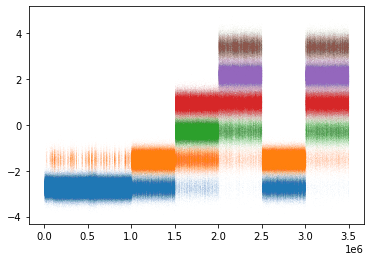

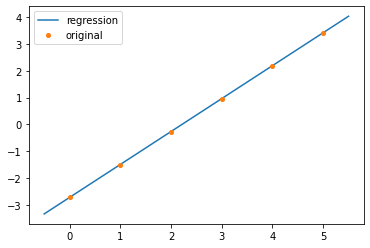

meanA : [-2.7281204  -1.49853395 -0.2689475   0.96063895  2.1902254   3.41981185]


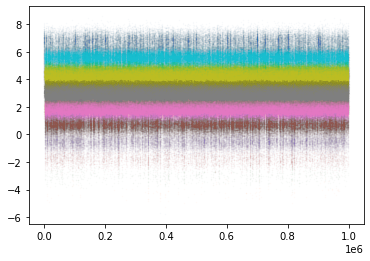

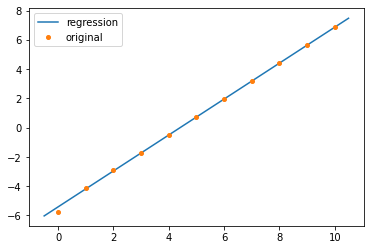

meanB : [-5.41787354 -4.19032957 -2.96278559 -1.73524161 -0.50769763  0.71984635
  1.94739033  3.17493431  4.40247829  5.63002227  6.85756625]


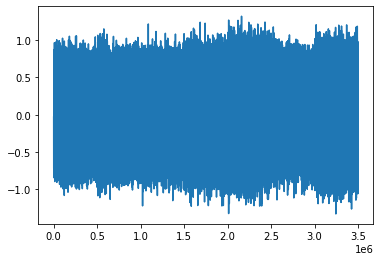

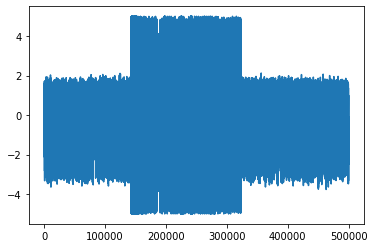

7358


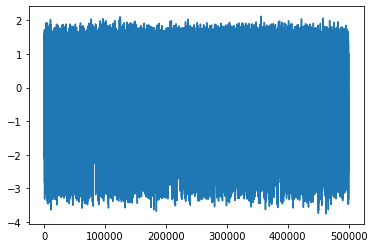

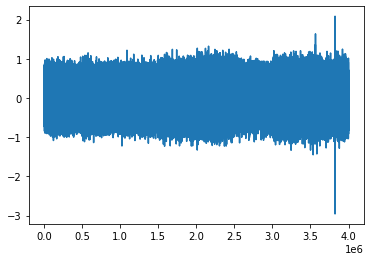

4000000
3500000


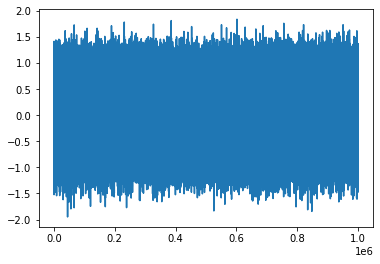

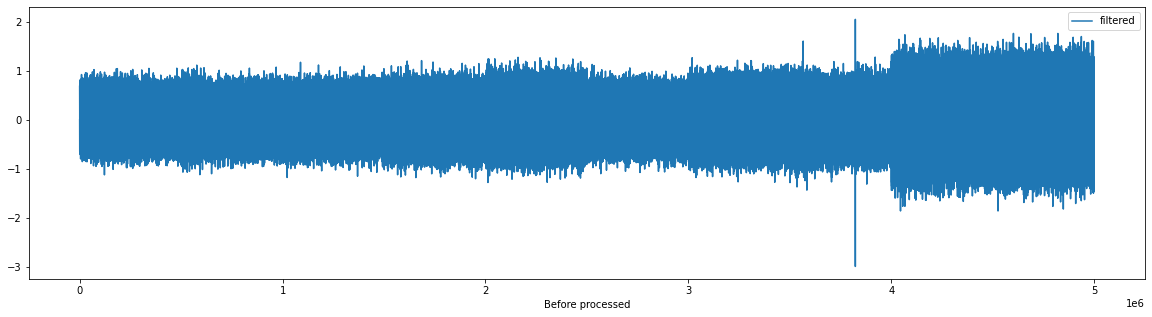

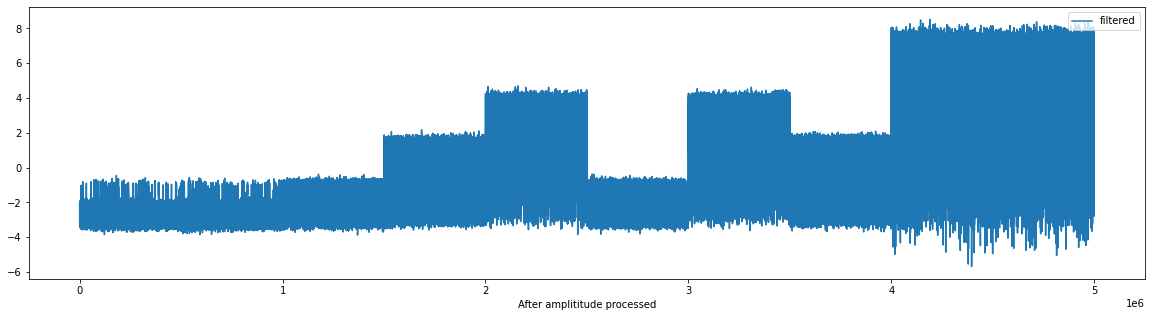

5000000


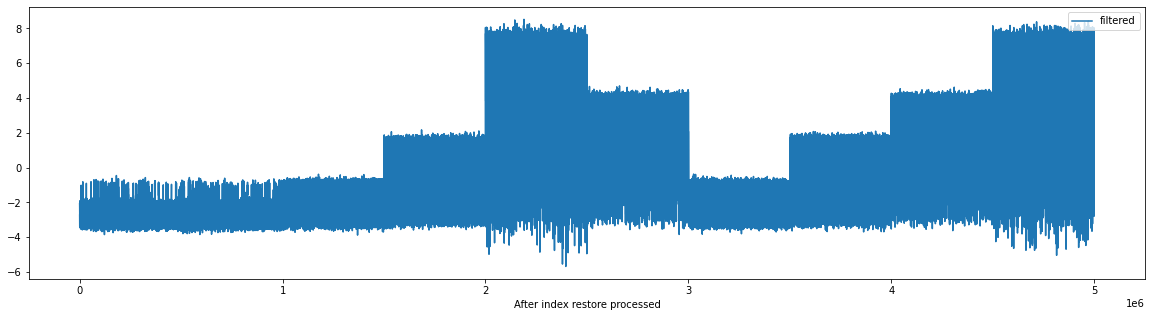

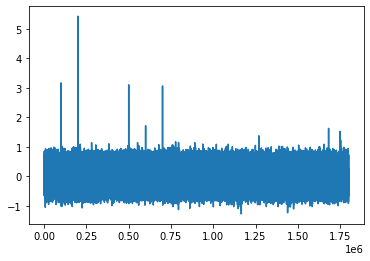

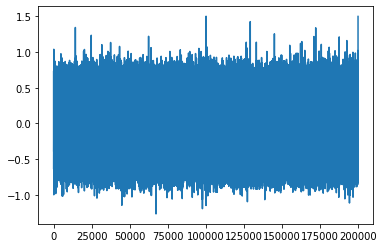

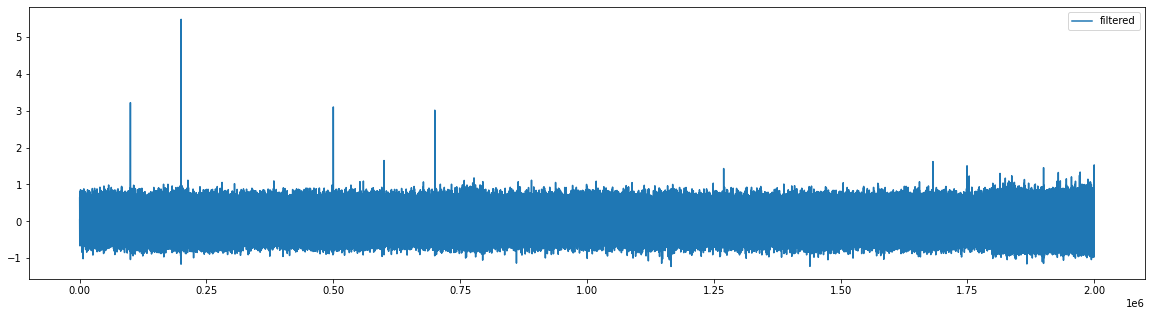

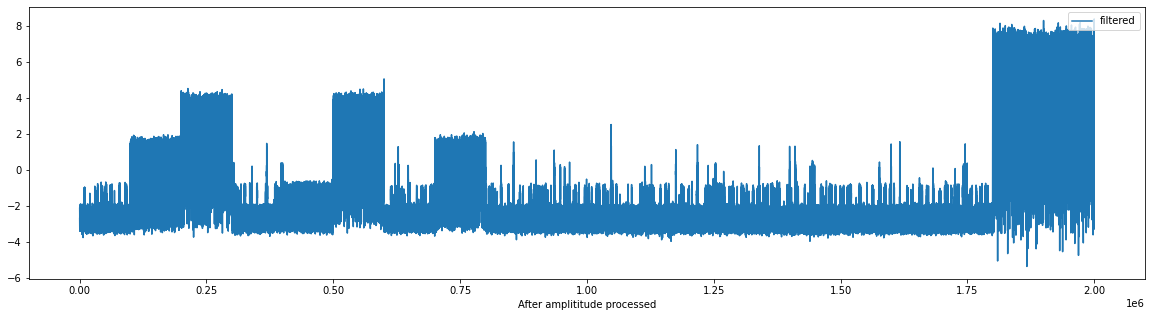

2000000


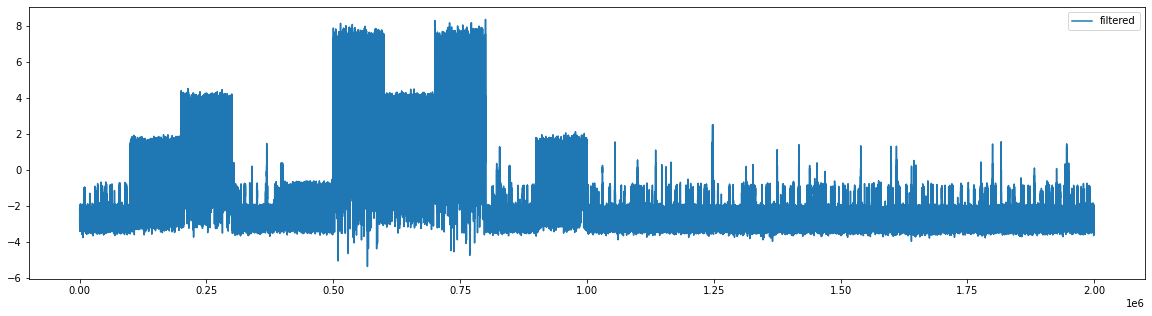

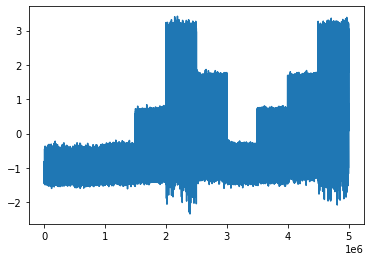

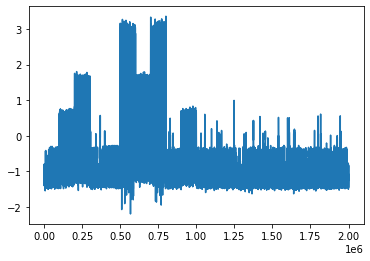

2020-05-23 22:41:07,943 INFO Reading and Normalizing Data Completed ...
2020-05-23 22:41:07,944 INFO [Reading Data] done in 16 s
2020-05-23 22:41:07,945 INFO Feature Enginnering Started ...


['signal', 'signal_shift_pos_1', 'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2', 'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2', 'category']
Mem. usage decreased to 133.51 MB (65.9 % reduction)


2020-05-23 22:41:13,629 INFO Feature Enginnering Completed ...
2020-05-23 22:41:13,632 INFO [Creating Features] done in 6 s
2020-05-23 22:41:13,633 INFO Training Wavenet model with 5 folds of GroupKFold Started ...


Mem. usage decreased to 45.78 MB (69.2 % reduction)
ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4
5000000 5
     time    signal  open_channels  group  category
0  0.0001 -1.140625              0      0         0
1  0.0002 -1.175781              0      0         0
2  0.0003 -1.003906              0      0         0
3  0.0004 -1.290039              0      0         0
4  0.0005 -1.295898              0      0         0
weights_: [ 0.36652399  0.46106257  0.82059173  0.67983748  1.12675802  1.63577934
  2.41635544  1.71516878  1.85390282  3.33929955 12.72060713]
nums_: 0     1240152
1      985865
2      553924
3      668609
4      403410
5      277877
6      188112
7      265015
8      245183
9      136120
10      35733
Name: open_channels, dtype: int64
cb_weights_: [0.97174558 0.97174558 0.97174558 0.97174558 0.97174567 0.97176004
 0.97227024 0.97176977 0.97179906 0.97596    1.27771292]
(1250, 4000, 11)
(1250, 40

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.4s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
train_x shape 1:  (1000, 4000, 9)
train_x shape 2:  (1000, 4000, 20)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


Epoch 1/180
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
125/125 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.8638
Epoch 00001: val_accuracy improved from -inf to 0.92664, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:43:43,899 INFO 
 epoch:000, F1Macro: 0.78673


125/125 [==============================] - 26s 204ms/step - loss: 0.4786 - accuracy: 0.8638 - val_loss: 0.6071 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 2/180
125/125 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9638
Epoch 00002: val_accuracy improved from 0.92664 to 0.96636, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:44:01,500 INFO 
 epoch:001, F1Macro: 0.92989


125/125 [==============================] - 18s 142ms/step - loss: 0.1487 - accuracy: 0.9638 - val_loss: 0.1823 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 3/180
125/125 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9684
Epoch 00003: val_accuracy improved from 0.96636 to 0.96773, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:44:19,383 INFO 
 epoch:002, F1Macro: 0.93611


125/125 [==============================] - 18s 142ms/step - loss: 0.1210 - accuracy: 0.9684 - val_loss: 0.1283 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 4/180
125/125 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9700
Epoch 00004: val_accuracy improved from 0.96773 to 0.96968, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:44:37,260 INFO 
 epoch:003, F1Macro: 0.94117


125/125 [==============================] - 18s 142ms/step - loss: 0.1077 - accuracy: 0.9700 - val_loss: 0.1003 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 5/180
125/125 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9704
Epoch 00005: val_accuracy improved from 0.96968 to 0.97018, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:44:55,054 INFO 
 epoch:004, F1Macro: 0.94171


125/125 [==============================] - 18s 141ms/step - loss: 0.1027 - accuracy: 0.9704 - val_loss: 0.0935 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 6/180
125/125 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9707
Epoch 00006: val_accuracy did not improve from 0.97018


2020-05-23 22:45:12,448 INFO 
 epoch:005, F1Macro: 0.94125


125/125 [==============================] - 17s 134ms/step - loss: 0.0982 - accuracy: 0.9707 - val_loss: 0.0938 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 7/180
125/125 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9706
Epoch 00007: val_accuracy improved from 0.97018 to 0.97042, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:45:29,804 INFO 
 epoch:006, F1Macro: 0.94159


125/125 [==============================] - 17s 138ms/step - loss: 0.0979 - accuracy: 0.9706 - val_loss: 0.0897 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 8/180
125/125 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9712
Epoch 00008: val_accuracy did not improve from 0.97042


2020-05-23 22:45:46,664 INFO 
 epoch:007, F1Macro: 0.94195


125/125 [==============================] - 17s 138ms/step - loss: 0.0932 - accuracy: 0.9712 - val_loss: 0.0882 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 9/180
125/125 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9714
Epoch 00009: val_accuracy improved from 0.97042 to 0.97074, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:46:04,602 INFO 
 epoch:008, F1Macro: 0.94261


125/125 [==============================] - 18s 143ms/step - loss: 0.0905 - accuracy: 0.9714 - val_loss: 0.0849 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 10/180
125/125 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9712
Epoch 00010: val_accuracy did not improve from 0.97074


2020-05-23 22:46:22,016 INFO 
 epoch:009, F1Macro: 0.94011


125/125 [==============================] - 17s 134ms/step - loss: 0.0899 - accuracy: 0.9712 - val_loss: 0.0893 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 11/180
125/125 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9714
Epoch 00011: val_accuracy did not improve from 0.97074


2020-05-23 22:46:38,916 INFO 
 epoch:010, F1Macro: 0.94213


125/125 [==============================] - 17s 134ms/step - loss: 0.0888 - accuracy: 0.9714 - val_loss: 0.0856 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 12/180
125/125 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9715
Epoch 00012: val_accuracy did not improve from 0.97074


2020-05-23 22:46:55,794 INFO 
 epoch:011, F1Macro: 0.93985


125/125 [==============================] - 17s 134ms/step - loss: 0.0874 - accuracy: 0.9715 - val_loss: 0.0881 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 13/180
125/125 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9715
Epoch 00013: val_accuracy did not improve from 0.97074


2020-05-23 22:47:12,638 INFO 
 epoch:012, F1Macro: 0.94128


125/125 [==============================] - 17s 134ms/step - loss: 0.0872 - accuracy: 0.9715 - val_loss: 0.0885 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 14/180
125/125 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9715
Epoch 00014: val_accuracy improved from 0.97074 to 0.97094, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:47:30,099 INFO 
 epoch:013, F1Macro: 0.94300


125/125 [==============================] - 18s 143ms/step - loss: 0.0865 - accuracy: 0.9715 - val_loss: 0.0815 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 15/180
125/125 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9713
Epoch 00015: val_accuracy did not improve from 0.97094


2020-05-23 22:47:47,561 INFO 
 epoch:014, F1Macro: 0.94064


125/125 [==============================] - 17s 134ms/step - loss: 0.0866 - accuracy: 0.9713 - val_loss: 0.0892 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 16/180
125/125 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9720
Epoch 00016: val_accuracy improved from 0.97094 to 0.97101, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:48:04,959 INFO 
 epoch:015, F1Macro: 0.94314


125/125 [==============================] - 18s 142ms/step - loss: 0.0834 - accuracy: 0.9720 - val_loss: 0.0806 - val_accuracy: 0.9710 - lr: 0.0010
Epoch 17/180
125/125 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9719
Epoch 00017: val_accuracy did not improve from 0.97101


2020-05-23 22:48:22,360 INFO 
 epoch:016, F1Macro: 0.94277


125/125 [==============================] - 17s 134ms/step - loss: 0.0827 - accuracy: 0.9719 - val_loss: 0.0817 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 18/180
125/125 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9718
Epoch 00018: val_accuracy did not improve from 0.97101


2020-05-23 22:48:39,272 INFO 
 epoch:017, F1Macro: 0.94267


125/125 [==============================] - 17s 134ms/step - loss: 0.0831 - accuracy: 0.9718 - val_loss: 0.0818 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 19/180
125/125 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9721
Epoch 00019: val_accuracy improved from 0.97101 to 0.97109, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:48:56,691 INFO 
 epoch:018, F1Macro: 0.94320


125/125 [==============================] - 18s 143ms/step - loss: 0.0813 - accuracy: 0.9721 - val_loss: 0.0791 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 20/180
125/125 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9721
Epoch 00020: val_accuracy did not improve from 0.97109


2020-05-23 22:49:14,118 INFO 
 epoch:019, F1Macro: 0.94261


125/125 [==============================] - 17s 134ms/step - loss: 0.0810 - accuracy: 0.9721 - val_loss: 0.0810 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 21/180
125/125 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9720
Epoch 00021: val_accuracy did not improve from 0.97109


2020-05-23 22:49:30,979 INFO 
 epoch:020, F1Macro: 0.94196


125/125 [==============================] - 17s 134ms/step - loss: 0.0810 - accuracy: 0.9720 - val_loss: 0.0812 - val_accuracy: 0.9705 - lr: 0.0010
Epoch 22/180
125/125 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9717
Epoch 00022: val_accuracy did not improve from 0.97109


2020-05-23 22:49:47,860 INFO 
 epoch:021, F1Macro: 0.94088


125/125 [==============================] - 17s 134ms/step - loss: 0.0822 - accuracy: 0.9717 - val_loss: 0.0955 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 23/180
125/125 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9706
Epoch 00023: val_accuracy did not improve from 0.97109


2020-05-23 22:50:04,721 INFO 
 epoch:022, F1Macro: 0.94281


125/125 [==============================] - 17s 134ms/step - loss: 0.0916 - accuracy: 0.9706 - val_loss: 0.0836 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 24/180
125/125 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9720
Epoch 00024: val_accuracy did not improve from 0.97109


2020-05-23 22:50:21,603 INFO 
 epoch:023, F1Macro: 0.94235


125/125 [==============================] - 17s 134ms/step - loss: 0.0818 - accuracy: 0.9720 - val_loss: 0.0812 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 25/180
125/125 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9721
Epoch 00025: val_accuracy did not improve from 0.97109


2020-05-23 22:50:38,480 INFO 
 epoch:024, F1Macro: 0.94170


125/125 [==============================] - 17s 134ms/step - loss: 0.0803 - accuracy: 0.9721 - val_loss: 0.0820 - val_accuracy: 0.9705 - lr: 0.0010
Epoch 26/180
125/125 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9723
Epoch 00026: val_accuracy did not improve from 0.97109


2020-05-23 22:50:55,309 INFO 
 epoch:025, F1Macro: 0.93903


125/125 [==============================] - 17s 134ms/step - loss: 0.0789 - accuracy: 0.9723 - val_loss: 0.0847 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 27/180
125/125 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9723
Epoch 00027: val_accuracy did not improve from 0.97109


2020-05-23 22:51:12,101 INFO 
 epoch:026, F1Macro: 0.94248


125/125 [==============================] - 17s 133ms/step - loss: 0.0788 - accuracy: 0.9723 - val_loss: 0.0801 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 28/180
125/125 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9724
Epoch 00028: val_accuracy did not improve from 0.97109


2020-05-23 22:51:29,053 INFO 
 epoch:027, F1Macro: 0.94275


125/125 [==============================] - 17s 135ms/step - loss: 0.0779 - accuracy: 0.9724 - val_loss: 0.0787 - val_accuracy: 0.9710 - lr: 0.0010
Epoch 29/180
125/125 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9724
Epoch 00029: val_accuracy did not improve from 0.97109


2020-05-23 22:51:45,932 INFO 
 epoch:028, F1Macro: 0.94279


125/125 [==============================] - 17s 134ms/step - loss: 0.0774 - accuracy: 0.9724 - val_loss: 0.0790 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 30/180
125/125 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9678
Epoch 00030: val_accuracy did not improve from 0.97109


2020-05-23 22:52:02,798 INFO 
 epoch:029, F1Macro: 0.88931


125/125 [==============================] - 17s 134ms/step - loss: 0.1040 - accuracy: 0.9678 - val_loss: 0.1785 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 31/180
125/125 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9691
Epoch 00031: val_accuracy did not improve from 0.97109


2020-05-23 22:52:19,679 INFO 
 epoch:030, F1Macro: 0.94249


125/125 [==============================] - 17s 134ms/step - loss: 0.1010 - accuracy: 0.9691 - val_loss: 0.0862 - val_accuracy: 0.9706 - lr: 3.3333e-04
Epoch 32/180
125/125 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9719
Epoch 00032: val_accuracy did not improve from 0.97109


2020-05-23 22:52:36,570 INFO 
 epoch:031, F1Macro: 0.94095


125/125 [==============================] - 17s 134ms/step - loss: 0.0859 - accuracy: 0.9719 - val_loss: 0.0848 - val_accuracy: 0.9702 - lr: 3.3333e-04
Epoch 33/180
125/125 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9721
Epoch 00033: val_accuracy did not improve from 0.97109


2020-05-23 22:52:53,439 INFO 
 epoch:032, F1Macro: 0.94276


125/125 [==============================] - 17s 134ms/step - loss: 0.0824 - accuracy: 0.9721 - val_loss: 0.0812 - val_accuracy: 0.9708 - lr: 3.3333e-04
Epoch 34/180
125/125 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9720
Epoch 00034: val_accuracy did not improve from 0.97109


2020-05-23 22:53:10,261 INFO 
 epoch:033, F1Macro: 0.94183


125/125 [==============================] - 17s 134ms/step - loss: 0.0822 - accuracy: 0.9720 - val_loss: 0.0819 - val_accuracy: 0.9705 - lr: 3.3333e-04
Epoch 35/180
125/125 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9722
Epoch 00035: val_accuracy did not improve from 0.97109


2020-05-23 22:53:27,148 INFO 
 epoch:034, F1Macro: 0.94252


125/125 [==============================] - 17s 134ms/step - loss: 0.0807 - accuracy: 0.9722 - val_loss: 0.0804 - val_accuracy: 0.9707 - lr: 3.3333e-04
Epoch 36/180
125/125 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9723
Epoch 00036: val_accuracy did not improve from 0.97109


2020-05-23 22:53:43,980 INFO 
 epoch:035, F1Macro: 0.94300


125/125 [==============================] - 17s 134ms/step - loss: 0.0797 - accuracy: 0.9723 - val_loss: 0.0794 - val_accuracy: 0.9709 - lr: 3.3333e-04
Epoch 37/180
125/125 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9724
Epoch 00037: val_accuracy did not improve from 0.97109


2020-05-23 22:54:00,877 INFO 
 epoch:036, F1Macro: 0.94312


125/125 [==============================] - 17s 134ms/step - loss: 0.0786 - accuracy: 0.9724 - val_loss: 0.0789 - val_accuracy: 0.9709 - lr: 3.3333e-04
Epoch 38/180
125/125 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9724
Epoch 00038: val_accuracy did not improve from 0.97109


2020-05-23 22:54:17,694 INFO 
 epoch:037, F1Macro: 0.94260


125/125 [==============================] - 17s 134ms/step - loss: 0.0783 - accuracy: 0.9724 - val_loss: 0.0794 - val_accuracy: 0.9707 - lr: 3.3333e-04
Epoch 39/180
125/125 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9724
Epoch 00039: val_accuracy did not improve from 0.97109


2020-05-23 22:54:34,587 INFO 
 epoch:038, F1Macro: 0.94278


125/125 [==============================] - 17s 134ms/step - loss: 0.0779 - accuracy: 0.9724 - val_loss: 0.0793 - val_accuracy: 0.9708 - lr: 3.3333e-04
Epoch 40/180
125/125 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9725
Epoch 00040: val_accuracy did not improve from 0.97109


2020-05-23 22:54:51,462 INFO 
 epoch:039, F1Macro: 0.94298


125/125 [==============================] - 17s 134ms/step - loss: 0.0773 - accuracy: 0.9725 - val_loss: 0.0794 - val_accuracy: 0.9709 - lr: 3.3333e-04
Epoch 41/180
125/125 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9726
Epoch 00041: val_accuracy did not improve from 0.97109


2020-05-23 22:55:08,312 INFO 
 epoch:040, F1Macro: 0.94286


125/125 [==============================] - 17s 134ms/step - loss: 0.0768 - accuracy: 0.9726 - val_loss: 0.0783 - val_accuracy: 0.9710 - lr: 2.0000e-04
Epoch 42/180
125/125 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9725
Epoch 00042: val_accuracy did not improve from 0.97109


2020-05-23 22:55:25,165 INFO 
 epoch:041, F1Macro: 0.94321


125/125 [==============================] - 17s 138ms/step - loss: 0.0769 - accuracy: 0.9725 - val_loss: 0.0775 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 43/180
125/125 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9726
Epoch 00043: val_accuracy improved from 0.97109 to 0.97111, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:55:43,141 INFO 
 epoch:042, F1Macro: 0.94322


125/125 [==============================] - 18s 142ms/step - loss: 0.0764 - accuracy: 0.9726 - val_loss: 0.0774 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 44/180
125/125 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9725
Epoch 00044: val_accuracy improved from 0.97111 to 0.97111, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:56:00,922 INFO 
 epoch:043, F1Macro: 0.94325


125/125 [==============================] - 18s 141ms/step - loss: 0.0765 - accuracy: 0.9725 - val_loss: 0.0769 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 45/180
125/125 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9726
Epoch 00045: val_accuracy did not improve from 0.97111


2020-05-23 22:56:18,210 INFO 
 epoch:044, F1Macro: 0.94310


125/125 [==============================] - 17s 133ms/step - loss: 0.0763 - accuracy: 0.9726 - val_loss: 0.0775 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 46/180
125/125 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9726
Epoch 00046: val_accuracy did not improve from 0.97111


2020-05-23 22:56:35,005 INFO 
 epoch:045, F1Macro: 0.94331


125/125 [==============================] - 17s 137ms/step - loss: 0.0760 - accuracy: 0.9726 - val_loss: 0.0775 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 47/180
125/125 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9726
Epoch 00047: val_accuracy did not improve from 0.97111


2020-05-23 22:56:52,304 INFO 
 epoch:046, F1Macro: 0.94331


125/125 [==============================] - 17s 134ms/step - loss: 0.0757 - accuracy: 0.9726 - val_loss: 0.0771 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 48/180
125/125 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9727
Epoch 00048: val_accuracy did not improve from 0.97111


2020-05-23 22:57:09,128 INFO 
 epoch:047, F1Macro: 0.94315


125/125 [==============================] - 17s 134ms/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 0.0772 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 49/180
125/125 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9726
Epoch 00049: val_accuracy improved from 0.97111 to 0.97112, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:57:26,465 INFO 
 epoch:048, F1Macro: 0.94319


125/125 [==============================] - 17s 138ms/step - loss: 0.0757 - accuracy: 0.9726 - val_loss: 0.0769 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 50/180
125/125 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9726
Epoch 00050: val_accuracy did not improve from 0.97112


2020-05-23 22:57:43,348 INFO 
 epoch:049, F1Macro: 0.94333


125/125 [==============================] - 17s 138ms/step - loss: 0.0757 - accuracy: 0.9726 - val_loss: 0.0775 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 51/180
125/125 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9727
Epoch 00051: val_accuracy improved from 0.97112 to 0.97115, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:58:01,355 INFO 
 epoch:050, F1Macro: 0.94343


125/125 [==============================] - 18s 142ms/step - loss: 0.0750 - accuracy: 0.9727 - val_loss: 0.0767 - val_accuracy: 0.9712 - lr: 1.4286e-04
Epoch 52/180
125/125 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9728
Epoch 00052: val_accuracy did not improve from 0.97115


2020-05-23 22:58:18,598 INFO 
 epoch:051, F1Macro: 0.94343


125/125 [==============================] - 17s 137ms/step - loss: 0.0750 - accuracy: 0.9728 - val_loss: 0.0769 - val_accuracy: 0.9711 - lr: 1.4286e-04
Epoch 53/180
125/125 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9728
Epoch 00053: val_accuracy improved from 0.97115 to 0.97118, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:58:36,454 INFO 
 epoch:052, F1Macro: 0.94344


125/125 [==============================] - 18s 142ms/step - loss: 0.0748 - accuracy: 0.9728 - val_loss: 0.0763 - val_accuracy: 0.9712 - lr: 1.4286e-04
Epoch 54/180
125/125 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9727
Epoch 00054: val_accuracy did not improve from 0.97118


2020-05-23 22:58:53,770 INFO 
 epoch:053, F1Macro: 0.94300


125/125 [==============================] - 17s 133ms/step - loss: 0.0748 - accuracy: 0.9727 - val_loss: 0.0773 - val_accuracy: 0.9710 - lr: 1.4286e-04
Epoch 55/180
125/125 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9728
Epoch 00055: val_accuracy improved from 0.97118 to 0.97126, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 22:59:11,091 INFO 
 epoch:054, F1Macro: 0.94349


125/125 [==============================] - 18s 142ms/step - loss: 0.0748 - accuracy: 0.9728 - val_loss: 0.0764 - val_accuracy: 0.9713 - lr: 1.4286e-04
Epoch 56/180
125/125 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9728
Epoch 00056: val_accuracy did not improve from 0.97126


2020-05-23 22:59:28,393 INFO 
 epoch:055, F1Macro: 0.94321


125/125 [==============================] - 17s 133ms/step - loss: 0.0744 - accuracy: 0.9728 - val_loss: 0.0770 - val_accuracy: 0.9711 - lr: 1.4286e-04
Epoch 57/180
125/125 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9728
Epoch 00057: val_accuracy did not improve from 0.97126


2020-05-23 22:59:45,248 INFO 
 epoch:056, F1Macro: 0.94344


125/125 [==============================] - 17s 134ms/step - loss: 0.0744 - accuracy: 0.9728 - val_loss: 0.0762 - val_accuracy: 0.9712 - lr: 1.4286e-04
Epoch 58/180
125/125 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9728
Epoch 00058: val_accuracy did not improve from 0.97126


2020-05-23 23:00:02,041 INFO 
 epoch:057, F1Macro: 0.94332


125/125 [==============================] - 17s 133ms/step - loss: 0.0746 - accuracy: 0.9728 - val_loss: 0.0773 - val_accuracy: 0.9711 - lr: 1.4286e-04
Epoch 59/180
125/125 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9728
Epoch 00059: val_accuracy did not improve from 0.97126


2020-05-23 23:00:18,870 INFO 
 epoch:058, F1Macro: 0.94346


125/125 [==============================] - 17s 134ms/step - loss: 0.0746 - accuracy: 0.9728 - val_loss: 0.0770 - val_accuracy: 0.9712 - lr: 1.4286e-04
Epoch 60/180
125/125 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9728
Epoch 00060: val_accuracy did not improve from 0.97126


2020-05-23 23:00:35,670 INFO 
 epoch:059, F1Macro: 0.94325


125/125 [==============================] - 17s 133ms/step - loss: 0.0742 - accuracy: 0.9728 - val_loss: 0.0765 - val_accuracy: 0.9711 - lr: 1.4286e-04
Epoch 61/180
125/125 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9729
Epoch 00061: val_accuracy did not improve from 0.97126


2020-05-23 23:00:52,522 INFO 
 epoch:060, F1Macro: 0.94352


125/125 [==============================] - 17s 138ms/step - loss: 0.0739 - accuracy: 0.9729 - val_loss: 0.0761 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 62/180
125/125 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9728
Epoch 00062: val_accuracy did not improve from 0.97126


2020-05-23 23:01:09,814 INFO 
 epoch:061, F1Macro: 0.94363


125/125 [==============================] - 17s 137ms/step - loss: 0.0740 - accuracy: 0.9728 - val_loss: 0.0760 - val_accuracy: 0.9713 - lr: 1.1111e-04
Epoch 63/180
125/125 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9728
Epoch 00063: val_accuracy improved from 0.97126 to 0.97127, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 23:01:27,642 INFO 
 epoch:062, F1Macro: 0.94360


125/125 [==============================] - 17s 138ms/step - loss: 0.0741 - accuracy: 0.9728 - val_loss: 0.0761 - val_accuracy: 0.9713 - lr: 1.1111e-04
Epoch 64/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9729
Epoch 00064: val_accuracy did not improve from 0.97127


2020-05-23 23:01:44,494 INFO 
 epoch:063, F1Macro: 0.94358


125/125 [==============================] - 17s 134ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.0763 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 65/180
125/125 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9727
Epoch 00065: val_accuracy did not improve from 0.97127


2020-05-23 23:02:01,333 INFO 
 epoch:064, F1Macro: 0.94353


125/125 [==============================] - 17s 134ms/step - loss: 0.0751 - accuracy: 0.9727 - val_loss: 0.0764 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 66/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9729
Epoch 00066: val_accuracy did not improve from 0.97127


2020-05-23 23:02:18,088 INFO 
 epoch:065, F1Macro: 0.94352


125/125 [==============================] - 17s 133ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.0763 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 67/180
125/125 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9729
Epoch 00067: val_accuracy did not improve from 0.97127


2020-05-23 23:02:34,903 INFO 
 epoch:066, F1Macro: 0.94343


125/125 [==============================] - 17s 134ms/step - loss: 0.0740 - accuracy: 0.9729 - val_loss: 0.0765 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 68/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9729
Epoch 00068: val_accuracy did not improve from 0.97127


2020-05-23 23:02:51,710 INFO 
 epoch:067, F1Macro: 0.94309


125/125 [==============================] - 17s 133ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.0767 - val_accuracy: 0.9711 - lr: 1.1111e-04
Epoch 69/180
125/125 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9729
Epoch 00069: val_accuracy did not improve from 0.97127


2020-05-23 23:03:08,559 INFO 
 epoch:068, F1Macro: 0.94345


125/125 [==============================] - 17s 134ms/step - loss: 0.0734 - accuracy: 0.9729 - val_loss: 0.0764 - val_accuracy: 0.9712 - lr: 1.1111e-04
Epoch 70/180
125/125 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9729
Epoch 00070: val_accuracy did not improve from 0.97127


2020-05-23 23:03:25,406 INFO 
 epoch:069, F1Macro: 0.94364


125/125 [==============================] - 17s 138ms/step - loss: 0.0735 - accuracy: 0.9729 - val_loss: 0.0761 - val_accuracy: 0.9713 - lr: 1.1111e-04
Epoch 71/180
125/125 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9730
Epoch 00071: val_accuracy did not improve from 0.97127


2020-05-23 23:03:42,915 INFO 
 epoch:070, F1Macro: 0.94357


125/125 [==============================] - 17s 135ms/step - loss: 0.0734 - accuracy: 0.9730 - val_loss: 0.0761 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 72/180
125/125 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9730
Epoch 00072: val_accuracy improved from 0.97127 to 0.97129, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 23:04:00,295 INFO 
 epoch:071, F1Macro: 0.94373


125/125 [==============================] - 18s 143ms/step - loss: 0.0731 - accuracy: 0.9730 - val_loss: 0.0760 - val_accuracy: 0.9713 - lr: 9.0909e-05
Epoch 73/180
125/125 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9729
Epoch 00073: val_accuracy did not improve from 0.97129


2020-05-23 23:04:17,781 INFO 
 epoch:072, F1Macro: 0.94354


125/125 [==============================] - 17s 134ms/step - loss: 0.0733 - accuracy: 0.9729 - val_loss: 0.0760 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 74/180
125/125 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9729
Epoch 00074: val_accuracy did not improve from 0.97129


2020-05-23 23:04:34,611 INFO 
 epoch:073, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0733 - accuracy: 0.9729 - val_loss: 0.0761 - val_accuracy: 0.9713 - lr: 9.0909e-05
Epoch 75/180
125/125 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9730
Epoch 00075: val_accuracy did not improve from 0.97129


2020-05-23 23:04:51,508 INFO 
 epoch:074, F1Macro: 0.94354


125/125 [==============================] - 17s 134ms/step - loss: 0.0732 - accuracy: 0.9730 - val_loss: 0.0760 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 76/180
125/125 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9730
Epoch 00076: val_accuracy did not improve from 0.97129


2020-05-23 23:05:08,378 INFO 
 epoch:075, F1Macro: 0.94363


125/125 [==============================] - 17s 134ms/step - loss: 0.0732 - accuracy: 0.9730 - val_loss: 0.0762 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 77/180
125/125 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9730
Epoch 00077: val_accuracy did not improve from 0.97129


2020-05-23 23:05:25,239 INFO 
 epoch:076, F1Macro: 0.94347


125/125 [==============================] - 17s 134ms/step - loss: 0.0731 - accuracy: 0.9730 - val_loss: 0.0760 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 78/180
125/125 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9730
Epoch 00078: val_accuracy improved from 0.97129 to 0.97132, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 23:05:42,565 INFO 
 epoch:077, F1Macro: 0.94377


125/125 [==============================] - 18s 142ms/step - loss: 0.0729 - accuracy: 0.9730 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 9.0909e-05
Epoch 79/180
125/125 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9729
Epoch 00079: val_accuracy did not improve from 0.97132


2020-05-23 23:05:59,948 INFO 
 epoch:078, F1Macro: 0.94356


125/125 [==============================] - 17s 134ms/step - loss: 0.0733 - accuracy: 0.9729 - val_loss: 0.0763 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 80/180
125/125 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9730
Epoch 00080: val_accuracy did not improve from 0.97132


2020-05-23 23:06:16,819 INFO 
 epoch:079, F1Macro: 0.94337


125/125 [==============================] - 17s 134ms/step - loss: 0.0729 - accuracy: 0.9730 - val_loss: 0.0761 - val_accuracy: 0.9712 - lr: 9.0909e-05
Epoch 81/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9730
Epoch 00081: val_accuracy did not improve from 0.97132


2020-05-23 23:06:33,724 INFO 
 epoch:080, F1Macro: 0.94366


125/125 [==============================] - 17s 134ms/step - loss: 0.0727 - accuracy: 0.9730 - val_loss: 0.0758 - val_accuracy: 0.9713 - lr: 7.6923e-05
Epoch 82/180
125/125 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9730
Epoch 00082: val_accuracy did not improve from 0.97132


2020-05-23 23:06:50,597 INFO 
 epoch:081, F1Macro: 0.94304


125/125 [==============================] - 17s 134ms/step - loss: 0.0730 - accuracy: 0.9730 - val_loss: 0.0764 - val_accuracy: 0.9710 - lr: 7.6923e-05
Epoch 83/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9731
Epoch 00083: val_accuracy did not improve from 0.97132


2020-05-23 23:07:07,462 INFO 
 epoch:082, F1Macro: 0.94351


125/125 [==============================] - 17s 134ms/step - loss: 0.0725 - accuracy: 0.9731 - val_loss: 0.0759 - val_accuracy: 0.9712 - lr: 7.6923e-05
Epoch 84/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9730
Epoch 00084: val_accuracy did not improve from 0.97132


2020-05-23 23:07:24,319 INFO 
 epoch:083, F1Macro: 0.94359


125/125 [==============================] - 17s 134ms/step - loss: 0.0727 - accuracy: 0.9730 - val_loss: 0.0762 - val_accuracy: 0.9712 - lr: 7.6923e-05
Epoch 85/180
125/125 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9730
Epoch 00085: val_accuracy did not improve from 0.97132


2020-05-23 23:07:41,203 INFO 
 epoch:084, F1Macro: 0.94360


125/125 [==============================] - 17s 134ms/step - loss: 0.0726 - accuracy: 0.9730 - val_loss: 0.0758 - val_accuracy: 0.9712 - lr: 7.6923e-05
Epoch 86/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9731
Epoch 00086: val_accuracy did not improve from 0.97132


2020-05-23 23:07:58,088 INFO 
 epoch:085, F1Macro: 0.94367


125/125 [==============================] - 17s 134ms/step - loss: 0.0725 - accuracy: 0.9731 - val_loss: 0.0759 - val_accuracy: 0.9713 - lr: 7.6923e-05
Epoch 87/180
125/125 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9730
Epoch 00087: val_accuracy did not improve from 0.97132


2020-05-23 23:08:14,987 INFO 
 epoch:086, F1Macro: 0.94314


125/125 [==============================] - 17s 134ms/step - loss: 0.0728 - accuracy: 0.9730 - val_loss: 0.0764 - val_accuracy: 0.9711 - lr: 7.6923e-05
Epoch 88/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9730
Epoch 00088: val_accuracy did not improve from 0.97132


2020-05-23 23:08:31,871 INFO 
 epoch:087, F1Macro: 0.94360


125/125 [==============================] - 17s 134ms/step - loss: 0.0727 - accuracy: 0.9730 - val_loss: 0.0762 - val_accuracy: 0.9712 - lr: 7.6923e-05
Epoch 89/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9731
Epoch 00089: val_accuracy improved from 0.97132 to 0.97133, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 23:08:49,293 INFO 
 epoch:088, F1Macro: 0.94375


125/125 [==============================] - 17s 138ms/step - loss: 0.0725 - accuracy: 0.9731 - val_loss: 0.0758 - val_accuracy: 0.9713 - lr: 7.6923e-05
Epoch 90/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731
Epoch 00090: val_accuracy did not improve from 0.97133


2020-05-23 23:09:06,196 INFO 
 epoch:089, F1Macro: 0.94354


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0762 - val_accuracy: 0.9712 - lr: 7.6923e-05
Epoch 91/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731
Epoch 00091: val_accuracy did not improve from 0.97133


2020-05-23 23:09:23,067 INFO 
 epoch:090, F1Macro: 0.94365


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 92/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9731
Epoch 00092: val_accuracy did not improve from 0.97133


2020-05-23 23:09:39,934 INFO 
 epoch:091, F1Macro: 0.94370


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9731 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 93/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9731
Epoch 00093: val_accuracy did not improve from 0.97133


2020-05-23 23:09:56,791 INFO 
 epoch:092, F1Macro: 0.94348


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9731 - val_loss: 0.0758 - val_accuracy: 0.9712 - lr: 1.0000e-05
Epoch 94/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00094: val_accuracy did not improve from 0.97133


2020-05-23 23:10:13,711 INFO 
 epoch:093, F1Macro: 0.94357


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 95/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731
Epoch 00095: val_accuracy did not improve from 0.97133


2020-05-23 23:10:30,631 INFO 
 epoch:094, F1Macro: 0.94369


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 96/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00096: val_accuracy did not improve from 0.97133


2020-05-23 23:10:47,507 INFO 
 epoch:095, F1Macro: 0.94376


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 97/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00097: val_accuracy did not improve from 0.97133


2020-05-23 23:11:04,364 INFO 
 epoch:096, F1Macro: 0.94373


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 98/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9732
Epoch 00098: val_accuracy did not improve from 0.97133


2020-05-23 23:11:21,197 INFO 
 epoch:097, F1Macro: 0.94374


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 99/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9732
Epoch 00099: val_accuracy did not improve from 0.97133


2020-05-23 23:11:38,100 INFO 
 epoch:098, F1Macro: 0.94369


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 100/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9731
Epoch 00100: val_accuracy did not improve from 0.97133


2020-05-23 23:11:54,965 INFO 
 epoch:099, F1Macro: 0.94368


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 101/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00101: val_accuracy did not improve from 0.97133


2020-05-23 23:12:11,813 INFO 
 epoch:100, F1Macro: 0.94366


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 102/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00102: val_accuracy did not improve from 0.97133


2020-05-23 23:12:28,675 INFO 
 epoch:101, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 103/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00103: val_accuracy did not improve from 0.97133


2020-05-23 23:12:45,526 INFO 
 epoch:102, F1Macro: 0.94368


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 104/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9731
Epoch 00104: val_accuracy did not improve from 0.97133


2020-05-23 23:13:02,414 INFO 
 epoch:103, F1Macro: 0.94365


125/125 [==============================] - 17s 134ms/step - loss: 0.0724 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 105/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00105: val_accuracy did not improve from 0.97133


2020-05-23 23:13:19,369 INFO 
 epoch:104, F1Macro: 0.94376


125/125 [==============================] - 17s 135ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 106/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00106: val_accuracy did not improve from 0.97133


2020-05-23 23:13:36,320 INFO 
 epoch:105, F1Macro: 0.94374


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 107/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00107: val_accuracy did not improve from 0.97133


2020-05-23 23:13:53,269 INFO 
 epoch:106, F1Macro: 0.94362


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 108/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9732
Epoch 00108: val_accuracy did not improve from 0.97133


2020-05-23 23:14:10,220 INFO 
 epoch:107, F1Macro: 0.94377


125/125 [==============================] - 17s 135ms/step - loss: 0.0722 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 109/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731
Epoch 00109: val_accuracy did not improve from 0.97133


2020-05-23 23:14:27,113 INFO 
 epoch:108, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 110/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00110: val_accuracy did not improve from 0.97133


2020-05-23 23:14:44,003 INFO 
 epoch:109, F1Macro: 0.94367


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 111/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00111: val_accuracy did not improve from 0.97133


2020-05-23 23:15:00,966 INFO 
 epoch:110, F1Macro: 0.94366


125/125 [==============================] - 17s 135ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 112/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00112: val_accuracy did not improve from 0.97133


2020-05-23 23:15:17,932 INFO 
 epoch:111, F1Macro: 0.94376


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 113/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00113: val_accuracy did not improve from 0.97133


2020-05-23 23:15:34,856 INFO 
 epoch:112, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 114/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731
Epoch 00114: val_accuracy did not improve from 0.97133


2020-05-23 23:15:51,773 INFO 
 epoch:113, F1Macro: 0.94373


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 115/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00115: val_accuracy did not improve from 0.97133


2020-05-23 23:16:08,669 INFO 
 epoch:114, F1Macro: 0.94367


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 116/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00116: val_accuracy did not improve from 0.97133


2020-05-23 23:16:25,621 INFO 
 epoch:115, F1Macro: 0.94371


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 117/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9732
Epoch 00117: val_accuracy did not improve from 0.97133


2020-05-23 23:16:42,480 INFO 
 epoch:116, F1Macro: 0.94376


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 118/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00118: val_accuracy did not improve from 0.97133


2020-05-23 23:16:59,424 INFO 
 epoch:117, F1Macro: 0.94373


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 119/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00119: val_accuracy did not improve from 0.97133


2020-05-23 23:17:16,368 INFO 
 epoch:118, F1Macro: 0.94372


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 120/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00120: val_accuracy did not improve from 0.97133


2020-05-23 23:17:33,266 INFO 
 epoch:119, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 121/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00121: val_accuracy did not improve from 0.97133


2020-05-23 23:17:50,150 INFO 
 epoch:120, F1Macro: 0.94354


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 122/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9731
Epoch 00122: val_accuracy did not improve from 0.97133


2020-05-23 23:18:07,067 INFO 
 epoch:121, F1Macro: 0.94369


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9731 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 123/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00123: val_accuracy did not improve from 0.97133


2020-05-23 23:18:24,024 INFO 
 epoch:122, F1Macro: 0.94368


125/125 [==============================] - 17s 135ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 124/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00124: val_accuracy did not improve from 0.97133


2020-05-23 23:18:40,936 INFO 
 epoch:123, F1Macro: 0.94367


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 125/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00125: val_accuracy did not improve from 0.97133


2020-05-23 23:18:57,798 INFO 
 epoch:124, F1Macro: 0.94378


125/125 [==============================] - 17s 138ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 126/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00126: val_accuracy did not improve from 0.97133


2020-05-23 23:19:15,195 INFO 
 epoch:125, F1Macro: 0.94373


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 127/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00127: val_accuracy did not improve from 0.97133


2020-05-23 23:19:32,050 INFO 
 epoch:126, F1Macro: 0.94368


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 128/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00128: val_accuracy did not improve from 0.97133


2020-05-23 23:19:48,955 INFO 
 epoch:127, F1Macro: 0.94356


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0758 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 129/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00129: val_accuracy did not improve from 0.97133


2020-05-23 23:20:05,818 INFO 
 epoch:128, F1Macro: 0.94368


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 130/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00130: val_accuracy did not improve from 0.97133


2020-05-23 23:20:22,673 INFO 
 epoch:129, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 131/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00131: val_accuracy did not improve from 0.97133


2020-05-23 23:20:39,536 INFO 
 epoch:130, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 132/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00132: val_accuracy did not improve from 0.97133


2020-05-23 23:20:56,427 INFO 
 epoch:131, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 133/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9731
Epoch 00133: val_accuracy did not improve from 0.97133


2020-05-23 23:21:13,312 INFO 
 epoch:132, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0724 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 134/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00134: val_accuracy improved from 0.97133 to 0.97135, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/0_fold/checkpoint-modelonly-0.h5


2020-05-23 23:21:30,670 INFO 
 epoch:133, F1Macro: 0.94384


125/125 [==============================] - 18s 142ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9714 - lr: 1.0000e-05
Epoch 135/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00135: val_accuracy did not improve from 0.97135


2020-05-23 23:21:48,052 INFO 
 epoch:134, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 136/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00136: val_accuracy did not improve from 0.97135


2020-05-23 23:22:04,924 INFO 
 epoch:135, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 137/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00137: val_accuracy did not improve from 0.97135


2020-05-23 23:22:21,771 INFO 
 epoch:136, F1Macro: 0.94368


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 138/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00138: val_accuracy did not improve from 0.97135


2020-05-23 23:22:38,582 INFO 
 epoch:137, F1Macro: 0.94377


125/125 [==============================] - 17s 133ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 139/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00139: val_accuracy did not improve from 0.97135


2020-05-23 23:22:55,434 INFO 
 epoch:138, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 140/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00140: val_accuracy did not improve from 0.97135


2020-05-23 23:23:12,290 INFO 
 epoch:139, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0758 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 141/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00141: val_accuracy did not improve from 0.97135


2020-05-23 23:23:29,126 INFO 
 epoch:140, F1Macro: 0.94360


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 142/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00142: val_accuracy did not improve from 0.97135


2020-05-23 23:23:46,019 INFO 
 epoch:141, F1Macro: 0.94371


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 143/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00143: val_accuracy did not improve from 0.97135


2020-05-23 23:24:02,872 INFO 
 epoch:142, F1Macro: 0.94374


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 144/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00144: val_accuracy did not improve from 0.97135


2020-05-23 23:24:19,649 INFO 
 epoch:143, F1Macro: 0.94372


125/125 [==============================] - 17s 133ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 145/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00145: val_accuracy did not improve from 0.97135


2020-05-23 23:24:36,466 INFO 
 epoch:144, F1Macro: 0.94379


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 146/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9733
Epoch 00146: val_accuracy did not improve from 0.97135


2020-05-23 23:24:53,290 INFO 
 epoch:145, F1Macro: 0.94374


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9733 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 147/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00147: val_accuracy did not improve from 0.97135


2020-05-23 23:25:10,057 INFO 
 epoch:146, F1Macro: 0.94379


125/125 [==============================] - 17s 133ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 148/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9732
Epoch 00148: val_accuracy did not improve from 0.97135


2020-05-23 23:25:26,843 INFO 
 epoch:147, F1Macro: 0.94367


125/125 [==============================] - 17s 133ms/step - loss: 0.0722 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 149/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00149: val_accuracy did not improve from 0.97135


2020-05-23 23:25:43,705 INFO 
 epoch:148, F1Macro: 0.94379


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 150/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00150: val_accuracy did not improve from 0.97135


2020-05-23 23:26:00,498 INFO 
 epoch:149, F1Macro: 0.94365


125/125 [==============================] - 17s 133ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 151/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00151: val_accuracy did not improve from 0.97135


2020-05-23 23:26:17,365 INFO 
 epoch:150, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 152/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00152: val_accuracy did not improve from 0.97135


2020-05-23 23:26:34,214 INFO 
 epoch:151, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 153/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00153: val_accuracy did not improve from 0.97135


2020-05-23 23:26:51,138 INFO 
 epoch:152, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 154/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00154: val_accuracy did not improve from 0.97135


2020-05-23 23:27:08,025 INFO 
 epoch:153, F1Macro: 0.94376


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 155/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00155: val_accuracy did not improve from 0.97135


2020-05-23 23:27:24,925 INFO 
 epoch:154, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 156/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9732
Epoch 00156: val_accuracy did not improve from 0.97135


2020-05-23 23:27:41,764 INFO 
 epoch:155, F1Macro: 0.94379


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.0757 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 157/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00157: val_accuracy did not improve from 0.97135


2020-05-23 23:27:58,620 INFO 
 epoch:156, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 158/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00158: val_accuracy did not improve from 0.97135


2020-05-23 23:28:15,469 INFO 
 epoch:157, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 159/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00159: val_accuracy did not improve from 0.97135


2020-05-23 23:28:32,301 INFO 
 epoch:158, F1Macro: 0.94383


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 160/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00160: val_accuracy did not improve from 0.97135


2020-05-23 23:28:49,170 INFO 
 epoch:159, F1Macro: 0.94379


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 161/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00161: val_accuracy did not improve from 0.97135


2020-05-23 23:29:06,049 INFO 
 epoch:160, F1Macro: 0.94376


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 162/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00162: val_accuracy did not improve from 0.97135


2020-05-23 23:29:22,907 INFO 
 epoch:161, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 163/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00163: val_accuracy did not improve from 0.97135


2020-05-23 23:29:39,755 INFO 
 epoch:162, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 164/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00164: val_accuracy did not improve from 0.97135


2020-05-23 23:29:56,572 INFO 
 epoch:163, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 165/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732
Epoch 00165: val_accuracy did not improve from 0.97135


2020-05-23 23:30:13,389 INFO 
 epoch:164, F1Macro: 0.94380


125/125 [==============================] - 17s 133ms/step - loss: 0.0720 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 166/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00166: val_accuracy did not improve from 0.97135


2020-05-23 23:30:30,141 INFO 
 epoch:165, F1Macro: 0.94379


125/125 [==============================] - 17s 133ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 167/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00167: val_accuracy did not improve from 0.97135


2020-05-23 23:30:46,987 INFO 
 epoch:166, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 168/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00168: val_accuracy did not improve from 0.97135


2020-05-23 23:31:03,806 INFO 
 epoch:167, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 169/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00169: val_accuracy did not improve from 0.97135


2020-05-23 23:31:20,655 INFO 
 epoch:168, F1Macro: 0.94380


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 170/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00170: val_accuracy did not improve from 0.97135


2020-05-23 23:31:37,458 INFO 
 epoch:169, F1Macro: 0.94383


125/125 [==============================] - 17s 133ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 171/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00171: val_accuracy did not improve from 0.97135


2020-05-23 23:31:54,324 INFO 
 epoch:170, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 172/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00172: val_accuracy did not improve from 0.97135


2020-05-23 23:32:11,201 INFO 
 epoch:171, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 173/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00173: val_accuracy did not improve from 0.97135


2020-05-23 23:32:28,059 INFO 
 epoch:172, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 174/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00174: val_accuracy did not improve from 0.97135


2020-05-23 23:32:44,918 INFO 
 epoch:173, F1Macro: 0.94379


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 175/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732
Epoch 00175: val_accuracy did not improve from 0.97135


2020-05-23 23:33:01,752 INFO 
 epoch:174, F1Macro: 0.94381


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 176/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00176: val_accuracy did not improve from 0.97135


2020-05-23 23:33:18,621 INFO 
 epoch:175, F1Macro: 0.94381


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 177/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00177: val_accuracy did not improve from 0.97135


2020-05-23 23:33:35,476 INFO 
 epoch:176, F1Macro: 0.94382


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 178/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9732
Epoch 00178: val_accuracy did not improve from 0.97135


2020-05-23 23:33:52,344 INFO 
 epoch:177, F1Macro: 0.94383


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 179/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00179: val_accuracy did not improve from 0.97135


2020-05-23 23:34:09,258 INFO 
 epoch:178, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06
Epoch 180/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732
Epoch 00180: val_accuracy did not improve from 0.97135


2020-05-23 23:34:26,132 INFO 
 epoch:179, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 0.0756 - val_accuracy: 0.9713 - lr: 1.0000e-06


2020-05-23 23:34:28,977 INFO Training fold 1 completed. macro f1 score : 0.94384


Train RF model: ion_switch/res/RFC/RF100-D12newreal/rf-f1-tn100-dn12.pkl


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.5min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.3min finished


Save RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f1-tn100-dn12.pkl
Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f1-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.3s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
train_x shape 1:  (1000, 4000, 9)
train_x shape 2:  (1000, 4000, 20)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


Epoch 1/180
125/125 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.8608
Epoch 00001: val_accuracy improved from -inf to 0.94957, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:55:04,047 INFO 
 epoch:000, F1Macro: 0.86189


125/125 [==============================] - 24s 195ms/step - loss: 0.4973 - accuracy: 0.8608 - val_loss: 0.7938 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 2/180
125/125 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9636
Epoch 00002: val_accuracy improved from 0.94957 to 0.96975, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:55:21,673 INFO 
 epoch:001, F1Macro: 0.93668


125/125 [==============================] - 18s 142ms/step - loss: 0.1591 - accuracy: 0.9636 - val_loss: 0.1796 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 3/180
125/125 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9687
Epoch 00003: val_accuracy improved from 0.96975 to 0.97073, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:55:39,526 INFO 
 epoch:002, F1Macro: 0.93794


125/125 [==============================] - 18s 142ms/step - loss: 0.1237 - accuracy: 0.9687 - val_loss: 0.1086 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 4/180
125/125 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9700
Epoch 00004: val_accuracy improved from 0.97073 to 0.97228, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:55:57,359 INFO 
 epoch:003, F1Macro: 0.94299


125/125 [==============================] - 18s 142ms/step - loss: 0.1106 - accuracy: 0.9700 - val_loss: 0.0910 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 5/180
125/125 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9701
Epoch 00005: val_accuracy did not improve from 0.97228


2020-05-23 23:56:14,646 INFO 
 epoch:004, F1Macro: 0.94096


125/125 [==============================] - 17s 134ms/step - loss: 0.1066 - accuracy: 0.9701 - val_loss: 0.0937 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 6/180
125/125 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9707
Epoch 00006: val_accuracy improved from 0.97228 to 0.97239, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:56:32,136 INFO 
 epoch:005, F1Macro: 0.94309


125/125 [==============================] - 18s 143ms/step - loss: 0.1003 - accuracy: 0.9707 - val_loss: 0.0860 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 7/180
125/125 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9706
Epoch 00007: val_accuracy improved from 0.97239 to 0.97244, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:56:49,984 INFO 
 epoch:006, F1Macro: 0.94330


125/125 [==============================] - 18s 141ms/step - loss: 0.0981 - accuracy: 0.9706 - val_loss: 0.0842 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 8/180
125/125 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9708
Epoch 00008: val_accuracy improved from 0.97244 to 0.97244, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:57:07,755 INFO 
 epoch:007, F1Macro: 0.94315


125/125 [==============================] - 17s 138ms/step - loss: 0.0951 - accuracy: 0.9708 - val_loss: 0.0831 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 9/180
125/125 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9709
Epoch 00009: val_accuracy did not improve from 0.97244


2020-05-23 23:57:24,586 INFO 
 epoch:008, F1Macro: 0.94278


125/125 [==============================] - 17s 134ms/step - loss: 0.0928 - accuracy: 0.9709 - val_loss: 0.0813 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 10/180
125/125 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9710
Epoch 00010: val_accuracy did not improve from 0.97244


2020-05-23 23:57:41,402 INFO 
 epoch:009, F1Macro: 0.94281


125/125 [==============================] - 17s 134ms/step - loss: 0.0918 - accuracy: 0.9710 - val_loss: 0.0822 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 11/180
125/125 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9710
Epoch 00011: val_accuracy improved from 0.97244 to 0.97277, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:57:58,736 INFO 
 epoch:010, F1Macro: 0.94338


125/125 [==============================] - 18s 142ms/step - loss: 0.0907 - accuracy: 0.9710 - val_loss: 0.0785 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 12/180
125/125 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9711
Epoch 00012: val_accuracy did not improve from 0.97277


2020-05-23 23:58:16,078 INFO 
 epoch:011, F1Macro: 0.94350


125/125 [==============================] - 17s 138ms/step - loss: 0.0889 - accuracy: 0.9711 - val_loss: 0.0797 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 13/180
125/125 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9711
Epoch 00013: val_accuracy did not improve from 0.97277


2020-05-23 23:58:33,391 INFO 
 epoch:012, F1Macro: 0.94305


125/125 [==============================] - 17s 133ms/step - loss: 0.0884 - accuracy: 0.9711 - val_loss: 0.0787 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 14/180
125/125 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9712
Epoch 00014: val_accuracy did not improve from 0.97277


2020-05-23 23:58:50,223 INFO 
 epoch:013, F1Macro: 0.94353


125/125 [==============================] - 18s 142ms/step - loss: 0.0874 - accuracy: 0.9712 - val_loss: 0.0770 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 15/180
125/125 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9712
Epoch 00015: val_accuracy did not improve from 0.97277


2020-05-23 23:59:08,128 INFO 
 epoch:014, F1Macro: 0.94122


125/125 [==============================] - 17s 134ms/step - loss: 0.0858 - accuracy: 0.9712 - val_loss: 0.0792 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 16/180
125/125 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9711
Epoch 00016: val_accuracy did not improve from 0.97277


2020-05-23 23:59:25,010 INFO 
 epoch:015, F1Macro: 0.94312


125/125 [==============================] - 17s 134ms/step - loss: 0.0858 - accuracy: 0.9711 - val_loss: 0.0789 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 17/180
125/125 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9713
Epoch 00017: val_accuracy did not improve from 0.97277


2020-05-23 23:59:41,883 INFO 
 epoch:016, F1Macro: 0.94317


125/125 [==============================] - 17s 134ms/step - loss: 0.0845 - accuracy: 0.9713 - val_loss: 0.0766 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 18/180
125/125 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9713
Epoch 00018: val_accuracy improved from 0.97277 to 0.97280, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-23 23:59:59,346 INFO 
 epoch:017, F1Macro: 0.94388


125/125 [==============================] - 18s 143ms/step - loss: 0.0844 - accuracy: 0.9713 - val_loss: 0.0754 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 19/180
125/125 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9713
Epoch 00019: val_accuracy did not improve from 0.97280


2020-05-24 00:00:16,725 INFO 
 epoch:018, F1Macro: 0.94054


125/125 [==============================] - 17s 134ms/step - loss: 0.0835 - accuracy: 0.9713 - val_loss: 0.0801 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 20/180
125/125 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9714
Epoch 00020: val_accuracy did not improve from 0.97280


2020-05-24 00:00:33,572 INFO 
 epoch:019, F1Macro: 0.94251


125/125 [==============================] - 17s 134ms/step - loss: 0.0833 - accuracy: 0.9714 - val_loss: 0.0789 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 21/180
125/125 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9714
Epoch 00021: val_accuracy did not improve from 0.97280


2020-05-24 00:00:50,456 INFO 
 epoch:020, F1Macro: 0.94196


125/125 [==============================] - 17s 134ms/step - loss: 0.0828 - accuracy: 0.9714 - val_loss: 0.0762 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 22/180
125/125 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9714
Epoch 00022: val_accuracy did not improve from 0.97280


2020-05-24 00:01:07,285 INFO 
 epoch:021, F1Macro: 0.94309


125/125 [==============================] - 17s 134ms/step - loss: 0.0823 - accuracy: 0.9714 - val_loss: 0.0794 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 23/180
125/125 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9710
Epoch 00023: val_accuracy did not improve from 0.97280


2020-05-24 00:01:24,157 INFO 
 epoch:022, F1Macro: 0.94179


125/125 [==============================] - 17s 134ms/step - loss: 0.0856 - accuracy: 0.9710 - val_loss: 0.0783 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 24/180
125/125 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9716
Epoch 00024: val_accuracy improved from 0.97280 to 0.97293, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:01:41,454 INFO 
 epoch:023, F1Macro: 0.94390


125/125 [==============================] - 18s 142ms/step - loss: 0.0810 - accuracy: 0.9716 - val_loss: 0.0740 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 25/180
125/125 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9717
Epoch 00025: val_accuracy did not improve from 0.97293


2020-05-24 00:01:58,948 INFO 
 epoch:024, F1Macro: 0.94400


125/125 [==============================] - 17s 138ms/step - loss: 0.0804 - accuracy: 0.9717 - val_loss: 0.0743 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 26/180
125/125 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9718
Epoch 00026: val_accuracy improved from 0.97293 to 0.97294, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:02:16,849 INFO 
 epoch:025, F1Macro: 0.94411


125/125 [==============================] - 18s 142ms/step - loss: 0.0799 - accuracy: 0.9718 - val_loss: 0.0740 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 27/180
125/125 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9717
Epoch 00027: val_accuracy improved from 0.97294 to 0.97304, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:02:34,702 INFO 
 epoch:026, F1Macro: 0.94424


125/125 [==============================] - 18s 142ms/step - loss: 0.0800 - accuracy: 0.9717 - val_loss: 0.0730 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 28/180
125/125 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9718
Epoch 00028: val_accuracy did not improve from 0.97304


2020-05-24 00:02:52,125 INFO 
 epoch:027, F1Macro: 0.94362


125/125 [==============================] - 17s 134ms/step - loss: 0.0797 - accuracy: 0.9718 - val_loss: 0.0746 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 29/180
125/125 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9719
Epoch 00029: val_accuracy did not improve from 0.97304


2020-05-24 00:03:08,988 INFO 
 epoch:028, F1Macro: 0.94383


125/125 [==============================] - 17s 134ms/step - loss: 0.0785 - accuracy: 0.9719 - val_loss: 0.0742 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 30/180
125/125 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9719
Epoch 00030: val_accuracy did not improve from 0.97304


2020-05-24 00:03:25,833 INFO 
 epoch:029, F1Macro: 0.94299


125/125 [==============================] - 17s 134ms/step - loss: 0.0785 - accuracy: 0.9719 - val_loss: 0.0753 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 31/180
125/125 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9721
Epoch 00031: val_accuracy improved from 0.97304 to 0.97305, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:03:43,207 INFO 
 epoch:030, F1Macro: 0.94417


125/125 [==============================] - 17s 138ms/step - loss: 0.0771 - accuracy: 0.9721 - val_loss: 0.0722 - val_accuracy: 0.9730 - lr: 3.3333e-04
Epoch 32/180
125/125 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9723
Epoch 00032: val_accuracy did not improve from 0.97305


2020-05-24 00:04:00,112 INFO 
 epoch:031, F1Macro: 0.94417


125/125 [==============================] - 17s 134ms/step - loss: 0.0762 - accuracy: 0.9723 - val_loss: 0.0719 - val_accuracy: 0.9730 - lr: 3.3333e-04
Epoch 33/180
125/125 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9723
Epoch 00033: val_accuracy improved from 0.97305 to 0.97307, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:04:17,499 INFO 
 epoch:032, F1Macro: 0.94410


125/125 [==============================] - 17s 138ms/step - loss: 0.0756 - accuracy: 0.9723 - val_loss: 0.0719 - val_accuracy: 0.9731 - lr: 3.3333e-04
Epoch 34/180
125/125 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9721
Epoch 00034: val_accuracy did not improve from 0.97307


2020-05-24 00:04:34,373 INFO 
 epoch:033, F1Macro: 0.94407


125/125 [==============================] - 17s 134ms/step - loss: 0.0769 - accuracy: 0.9721 - val_loss: 0.0723 - val_accuracy: 0.9730 - lr: 3.3333e-04
Epoch 35/180
125/125 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9722
Epoch 00035: val_accuracy did not improve from 0.97307


2020-05-24 00:04:51,275 INFO 
 epoch:034, F1Macro: 0.94403


125/125 [==============================] - 17s 134ms/step - loss: 0.0760 - accuracy: 0.9722 - val_loss: 0.0726 - val_accuracy: 0.9729 - lr: 3.3333e-04
Epoch 36/180
125/125 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9722
Epoch 00036: val_accuracy did not improve from 0.97307


2020-05-24 00:05:08,198 INFO 
 epoch:035, F1Macro: 0.94398


125/125 [==============================] - 17s 134ms/step - loss: 0.0762 - accuracy: 0.9722 - val_loss: 0.0721 - val_accuracy: 0.9730 - lr: 3.3333e-04
Epoch 37/180
125/125 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9723
Epoch 00037: val_accuracy did not improve from 0.97307


2020-05-24 00:05:25,078 INFO 
 epoch:036, F1Macro: 0.94314


125/125 [==============================] - 17s 134ms/step - loss: 0.0756 - accuracy: 0.9723 - val_loss: 0.0735 - val_accuracy: 0.9725 - lr: 3.3333e-04
Epoch 38/180
125/125 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9723
Epoch 00038: val_accuracy did not improve from 0.97307


2020-05-24 00:05:41,969 INFO 
 epoch:037, F1Macro: 0.94257


125/125 [==============================] - 17s 134ms/step - loss: 0.0754 - accuracy: 0.9723 - val_loss: 0.0735 - val_accuracy: 0.9726 - lr: 3.3333e-04
Epoch 39/180
125/125 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9723
Epoch 00039: val_accuracy did not improve from 0.97307


2020-05-24 00:05:58,819 INFO 
 epoch:038, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0755 - accuracy: 0.9723 - val_loss: 0.0723 - val_accuracy: 0.9729 - lr: 3.3333e-04
Epoch 40/180
125/125 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9723
Epoch 00040: val_accuracy did not improve from 0.97307


2020-05-24 00:06:15,723 INFO 
 epoch:039, F1Macro: 0.94398


125/125 [==============================] - 17s 134ms/step - loss: 0.0753 - accuracy: 0.9723 - val_loss: 0.0720 - val_accuracy: 0.9730 - lr: 3.3333e-04
Epoch 41/180
125/125 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9724
Epoch 00041: val_accuracy improved from 0.97307 to 0.97310, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:06:33,090 INFO 
 epoch:040, F1Macro: 0.94406


125/125 [==============================] - 17s 138ms/step - loss: 0.0747 - accuracy: 0.9724 - val_loss: 0.0714 - val_accuracy: 0.9731 - lr: 2.0000e-04
Epoch 42/180
125/125 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9724
Epoch 00042: val_accuracy did not improve from 0.97310


2020-05-24 00:06:49,995 INFO 
 epoch:041, F1Macro: 0.94391


125/125 [==============================] - 17s 134ms/step - loss: 0.0749 - accuracy: 0.9724 - val_loss: 0.0720 - val_accuracy: 0.9729 - lr: 2.0000e-04
Epoch 43/180
125/125 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9724
Epoch 00043: val_accuracy did not improve from 0.97310


2020-05-24 00:07:06,890 INFO 
 epoch:042, F1Macro: 0.94396


125/125 [==============================] - 17s 134ms/step - loss: 0.0747 - accuracy: 0.9724 - val_loss: 0.0723 - val_accuracy: 0.9729 - lr: 2.0000e-04
Epoch 44/180
125/125 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9723
Epoch 00044: val_accuracy did not improve from 0.97310


2020-05-24 00:07:23,826 INFO 
 epoch:043, F1Macro: 0.94305


125/125 [==============================] - 17s 134ms/step - loss: 0.0753 - accuracy: 0.9723 - val_loss: 0.0727 - val_accuracy: 0.9728 - lr: 2.0000e-04
Epoch 45/180
125/125 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9724
Epoch 00045: val_accuracy did not improve from 0.97310


2020-05-24 00:07:40,752 INFO 
 epoch:044, F1Macro: 0.94402


125/125 [==============================] - 17s 134ms/step - loss: 0.0745 - accuracy: 0.9724 - val_loss: 0.0715 - val_accuracy: 0.9730 - lr: 2.0000e-04
Epoch 46/180
125/125 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9724
Epoch 00046: val_accuracy did not improve from 0.97310


2020-05-24 00:07:57,663 INFO 
 epoch:045, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0744 - accuracy: 0.9724 - val_loss: 0.0721 - val_accuracy: 0.9729 - lr: 2.0000e-04
Epoch 47/180
125/125 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9725
Epoch 00047: val_accuracy improved from 0.97310 to 0.97311, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:08:15,228 INFO 
 epoch:046, F1Macro: 0.94426


125/125 [==============================] - 18s 143ms/step - loss: 0.0744 - accuracy: 0.9725 - val_loss: 0.0714 - val_accuracy: 0.9731 - lr: 2.0000e-04
Epoch 48/180
125/125 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9724
Epoch 00048: val_accuracy improved from 0.97311 to 0.97314, saving model to ion_switch/res/wavenet-dlr-res/WaveNet-DLR-FOCALLOSS-ClassifierCBRW-Prob11-NESCAL_len4000_bs16_lr0.001_tn100_dn12/all-v8-4/1_fold/checkpoint-modelonly-1.h5


2020-05-24 00:08:33,111 INFO 
 epoch:047, F1Macro: 0.94425


125/125 [==============================] - 17s 138ms/step - loss: 0.0745 - accuracy: 0.9724 - val_loss: 0.0713 - val_accuracy: 0.9731 - lr: 2.0000e-04
Epoch 49/180
125/125 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9724
Epoch 00049: val_accuracy did not improve from 0.97314


2020-05-24 00:08:50,060 INFO 
 epoch:048, F1Macro: 0.94407


125/125 [==============================] - 17s 135ms/step - loss: 0.0746 - accuracy: 0.9724 - val_loss: 0.0715 - val_accuracy: 0.9730 - lr: 2.0000e-04
Epoch 50/180
125/125 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9724
Epoch 00050: val_accuracy did not improve from 0.97314


2020-05-24 00:09:06,996 INFO 
 epoch:049, F1Macro: 0.94338


125/125 [==============================] - 17s 134ms/step - loss: 0.0746 - accuracy: 0.9724 - val_loss: 0.0724 - val_accuracy: 0.9729 - lr: 2.0000e-04
Epoch 51/180
125/125 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9726
Epoch 00051: val_accuracy did not improve from 0.97314


2020-05-24 00:09:23,916 INFO 
 epoch:050, F1Macro: 0.94406


125/125 [==============================] - 17s 134ms/step - loss: 0.0739 - accuracy: 0.9726 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.4286e-04
Epoch 52/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9726
Epoch 00052: val_accuracy did not improve from 0.97314


2020-05-24 00:09:40,859 INFO 
 epoch:051, F1Macro: 0.94396


125/125 [==============================] - 17s 135ms/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.4286e-04
Epoch 53/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9726
Epoch 00053: val_accuracy did not improve from 0.97314


2020-05-24 00:09:57,809 INFO 
 epoch:052, F1Macro: 0.94406


125/125 [==============================] - 17s 135ms/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.0716 - val_accuracy: 0.9731 - lr: 1.4286e-04
Epoch 54/180
125/125 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9725
Epoch 00054: val_accuracy did not improve from 0.97314


2020-05-24 00:10:14,753 INFO 
 epoch:053, F1Macro: 0.94405


125/125 [==============================] - 17s 135ms/step - loss: 0.0738 - accuracy: 0.9725 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.4286e-04
Epoch 55/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9726
Epoch 00055: val_accuracy did not improve from 0.97314


2020-05-24 00:10:31,692 INFO 
 epoch:054, F1Macro: 0.94411


125/125 [==============================] - 17s 134ms/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.0714 - val_accuracy: 0.9731 - lr: 1.4286e-04
Epoch 56/180
125/125 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9727
Epoch 00056: val_accuracy did not improve from 0.97314


2020-05-24 00:10:48,632 INFO 
 epoch:055, F1Macro: 0.94372


125/125 [==============================] - 17s 134ms/step - loss: 0.0734 - accuracy: 0.9727 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.4286e-04
Epoch 57/180
125/125 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9727
Epoch 00057: val_accuracy did not improve from 0.97314


2020-05-24 00:11:05,552 INFO 
 epoch:056, F1Macro: 0.94383


125/125 [==============================] - 17s 134ms/step - loss: 0.0734 - accuracy: 0.9727 - val_loss: 0.0722 - val_accuracy: 0.9729 - lr: 1.4286e-04
Epoch 58/180
125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9726
Epoch 00058: val_accuracy did not improve from 0.97314


2020-05-24 00:11:22,478 INFO 
 epoch:057, F1Macro: 0.94378


125/125 [==============================] - 17s 134ms/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.0726 - val_accuracy: 0.9728 - lr: 1.4286e-04
Epoch 59/180
125/125 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9726
Epoch 00059: val_accuracy did not improve from 0.97314


2020-05-24 00:11:39,407 INFO 
 epoch:058, F1Macro: 0.94412


125/125 [==============================] - 17s 134ms/step - loss: 0.0736 - accuracy: 0.9726 - val_loss: 0.0715 - val_accuracy: 0.9730 - lr: 1.4286e-04
Epoch 60/180
125/125 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9727
Epoch 00060: val_accuracy did not improve from 0.97314


2020-05-24 00:11:56,380 INFO 
 epoch:059, F1Macro: 0.94334


125/125 [==============================] - 17s 135ms/step - loss: 0.0733 - accuracy: 0.9727 - val_loss: 0.0723 - val_accuracy: 0.9727 - lr: 1.4286e-04
Epoch 61/180
125/125 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9727
Epoch 00061: val_accuracy did not improve from 0.97314


2020-05-24 00:12:13,292 INFO 
 epoch:060, F1Macro: 0.94414


125/125 [==============================] - 17s 134ms/step - loss: 0.0732 - accuracy: 0.9727 - val_loss: 0.0715 - val_accuracy: 0.9731 - lr: 1.1111e-04
Epoch 62/180
125/125 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9727
Epoch 00062: val_accuracy did not improve from 0.97314


2020-05-24 00:12:30,242 INFO 
 epoch:061, F1Macro: 0.94363


125/125 [==============================] - 17s 135ms/step - loss: 0.0732 - accuracy: 0.9727 - val_loss: 0.0720 - val_accuracy: 0.9729 - lr: 1.1111e-04
Epoch 63/180
125/125 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9727
Epoch 00063: val_accuracy did not improve from 0.97314


2020-05-24 00:12:47,144 INFO 
 epoch:062, F1Macro: 0.94414


125/125 [==============================] - 17s 134ms/step - loss: 0.0732 - accuracy: 0.9727 - val_loss: 0.0714 - val_accuracy: 0.9730 - lr: 1.1111e-04
Epoch 64/180
125/125 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9727
Epoch 00064: val_accuracy did not improve from 0.97314


2020-05-24 00:13:04,067 INFO 
 epoch:063, F1Macro: 0.94387


125/125 [==============================] - 17s 134ms/step - loss: 0.0729 - accuracy: 0.9727 - val_loss: 0.0715 - val_accuracy: 0.9730 - lr: 1.1111e-04
Epoch 65/180
125/125 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9726
Epoch 00065: val_accuracy did not improve from 0.97314


2020-05-24 00:13:20,997 INFO 
 epoch:064, F1Macro: 0.94412


125/125 [==============================] - 17s 134ms/step - loss: 0.0735 - accuracy: 0.9726 - val_loss: 0.0715 - val_accuracy: 0.9731 - lr: 1.1111e-04
Epoch 66/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728
Epoch 00066: val_accuracy did not improve from 0.97314


2020-05-24 00:13:37,896 INFO 
 epoch:065, F1Macro: 0.94425


125/125 [==============================] - 17s 134ms/step - loss: 0.0727 - accuracy: 0.9728 - val_loss: 0.0713 - val_accuracy: 0.9731 - lr: 1.1111e-04
Epoch 67/180
125/125 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9728
Epoch 00067: val_accuracy did not improve from 0.97314


2020-05-24 00:13:54,839 INFO 
 epoch:066, F1Macro: 0.94399


125/125 [==============================] - 17s 135ms/step - loss: 0.0731 - accuracy: 0.9728 - val_loss: 0.0715 - val_accuracy: 0.9730 - lr: 1.1111e-04
Epoch 68/180
125/125 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9728
Epoch 00068: val_accuracy did not improve from 0.97314


2020-05-24 00:14:11,774 INFO 
 epoch:067, F1Macro: 0.94381


125/125 [==============================] - 17s 134ms/step - loss: 0.0728 - accuracy: 0.9728 - val_loss: 0.0719 - val_accuracy: 0.9730 - lr: 1.1111e-04
Epoch 69/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728
Epoch 00069: val_accuracy did not improve from 0.97314


2020-05-24 00:14:28,676 INFO 
 epoch:068, F1Macro: 0.94404


125/125 [==============================] - 17s 134ms/step - loss: 0.0727 - accuracy: 0.9728 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.1111e-04
Epoch 70/180
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728
Epoch 00070: val_accuracy did not improve from 0.97314


2020-05-24 00:14:45,640 INFO 
 epoch:069, F1Macro: 0.94392


125/125 [==============================] - 17s 135ms/step - loss: 0.0727 - accuracy: 0.9728 - val_loss: 0.0716 - val_accuracy: 0.9729 - lr: 1.1111e-04
Epoch 71/180
125/125 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9728
Epoch 00071: val_accuracy did not improve from 0.97314


2020-05-24 00:15:02,602 INFO 
 epoch:070, F1Macro: 0.94401


125/125 [==============================] - 17s 135ms/step - loss: 0.0726 - accuracy: 0.9728 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 72/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9728
Epoch 00072: val_accuracy did not improve from 0.97314


2020-05-24 00:15:19,523 INFO 
 epoch:071, F1Macro: 0.94389


125/125 [==============================] - 17s 134ms/step - loss: 0.0725 - accuracy: 0.9728 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 73/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9728
Epoch 00073: val_accuracy did not improve from 0.97314


2020-05-24 00:15:36,484 INFO 
 epoch:072, F1Macro: 0.94409


125/125 [==============================] - 17s 135ms/step - loss: 0.0725 - accuracy: 0.9728 - val_loss: 0.0714 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 74/180
125/125 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9728
Epoch 00074: val_accuracy did not improve from 0.97314


2020-05-24 00:15:53,392 INFO 
 epoch:073, F1Macro: 0.94370


125/125 [==============================] - 17s 134ms/step - loss: 0.0726 - accuracy: 0.9728 - val_loss: 0.0719 - val_accuracy: 0.9729 - lr: 9.0909e-05
Epoch 75/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9728
Epoch 00075: val_accuracy did not improve from 0.97314


2020-05-24 00:16:10,320 INFO 
 epoch:074, F1Macro: 0.94375


125/125 [==============================] - 17s 134ms/step - loss: 0.0724 - accuracy: 0.9728 - val_loss: 0.0721 - val_accuracy: 0.9729 - lr: 9.0909e-05
Epoch 76/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9729
Epoch 00076: val_accuracy did not improve from 0.97314


2020-05-24 00:16:27,221 INFO 
 epoch:075, F1Macro: 0.94409


125/125 [==============================] - 17s 134ms/step - loss: 0.0725 - accuracy: 0.9729 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 77/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9728
Epoch 00077: val_accuracy did not improve from 0.97314


2020-05-24 00:16:44,143 INFO 
 epoch:076, F1Macro: 0.94389


125/125 [==============================] - 17s 134ms/step - loss: 0.0724 - accuracy: 0.9728 - val_loss: 0.0719 - val_accuracy: 0.9729 - lr: 9.0909e-05
Epoch 78/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9729
Epoch 00078: val_accuracy did not improve from 0.97314


2020-05-24 00:17:01,106 INFO 
 epoch:077, F1Macro: 0.94374


125/125 [==============================] - 17s 135ms/step - loss: 0.0724 - accuracy: 0.9729 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 9.0909e-05
Epoch 79/180
125/125 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9728
Epoch 00079: val_accuracy did not improve from 0.97314


2020-05-24 00:17:17,991 INFO 
 epoch:078, F1Macro: 0.94418


125/125 [==============================] - 17s 134ms/step - loss: 0.0725 - accuracy: 0.9728 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 80/180
125/125 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9728
Epoch 00080: val_accuracy did not improve from 0.97314


2020-05-24 00:17:34,881 INFO 
 epoch:079, F1Macro: 0.94409


125/125 [==============================] - 17s 134ms/step - loss: 0.0724 - accuracy: 0.9728 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 9.0909e-05
Epoch 81/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9729
Epoch 00081: val_accuracy did not improve from 0.97314


2020-05-24 00:17:51,858 INFO 
 epoch:080, F1Macro: 0.94392


125/125 [==============================] - 17s 135ms/step - loss: 0.0721 - accuracy: 0.9729 - val_loss: 0.0718 - val_accuracy: 0.9729 - lr: 7.6923e-05
Epoch 82/180
125/125 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9729
Epoch 00082: val_accuracy did not improve from 0.97314


2020-05-24 00:18:08,738 INFO 
 epoch:081, F1Macro: 0.94386


125/125 [==============================] - 17s 134ms/step - loss: 0.0723 - accuracy: 0.9729 - val_loss: 0.0720 - val_accuracy: 0.9729 - lr: 7.6923e-05
Epoch 83/180
125/125 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9729
Epoch 00083: val_accuracy did not improve from 0.97314


2020-05-24 00:18:25,644 INFO 
 epoch:082, F1Macro: 0.94397


125/125 [==============================] - 17s 134ms/step - loss: 0.0720 - accuracy: 0.9729 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 7.6923e-05
Epoch 84/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9729
Epoch 00084: val_accuracy did not improve from 0.97314


2020-05-24 00:18:42,525 INFO 
 epoch:083, F1Macro: 0.94390


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9729 - val_loss: 0.0716 - val_accuracy: 0.9729 - lr: 7.6923e-05
Epoch 85/180
125/125 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9729
Epoch 00085: val_accuracy did not improve from 0.97314


2020-05-24 00:18:59,424 INFO 
 epoch:084, F1Macro: 0.94405


125/125 [==============================] - 17s 134ms/step - loss: 0.0721 - accuracy: 0.9729 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 7.6923e-05
Epoch 86/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9730
Epoch 00086: val_accuracy did not improve from 0.97314


2020-05-24 00:19:16,320 INFO 
 epoch:085, F1Macro: 0.94400


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 7.6923e-05
Epoch 87/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9729
Epoch 00087: val_accuracy did not improve from 0.97314


2020-05-24 00:19:33,153 INFO 
 epoch:086, F1Macro: 0.94374


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9729 - val_loss: 0.0719 - val_accuracy: 0.9729 - lr: 7.6923e-05
Epoch 88/180
125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9729
Epoch 00088: val_accuracy did not improve from 0.97314


2020-05-24 00:19:50,004 INFO 
 epoch:087, F1Macro: 0.94365


125/125 [==============================] - 17s 134ms/step - loss: 0.0722 - accuracy: 0.9729 - val_loss: 0.0719 - val_accuracy: 0.9728 - lr: 7.6923e-05
Epoch 89/180
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9730
Epoch 00089: val_accuracy did not improve from 0.97314


2020-05-24 00:20:06,886 INFO 
 epoch:088, F1Macro: 0.94382


125/125 [==============================] - 17s 134ms/step - loss: 0.0719 - accuracy: 0.9730 - val_loss: 0.0718 - val_accuracy: 0.9729 - lr: 7.6923e-05
Epoch 90/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9730
Epoch 00090: val_accuracy did not improve from 0.97314


2020-05-24 00:20:23,793 INFO 
 epoch:089, F1Macro: 0.94397


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 7.6923e-05
Epoch 91/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9730
Epoch 00091: val_accuracy did not improve from 0.97314


2020-05-24 00:20:40,702 INFO 
 epoch:090, F1Macro: 0.94403


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 92/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00092: val_accuracy did not improve from 0.97314


2020-05-24 00:20:57,600 INFO 
 epoch:091, F1Macro: 0.94401


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 93/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9730
Epoch 00093: val_accuracy did not improve from 0.97314


2020-05-24 00:21:14,487 INFO 
 epoch:092, F1Macro: 0.94398


125/125 [==============================] - 17s 134ms/step - loss: 0.0717 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 94/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9730
Epoch 00094: val_accuracy did not improve from 0.97314


2020-05-24 00:21:31,373 INFO 
 epoch:093, F1Macro: 0.94387


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 95/180
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9730
Epoch 00095: val_accuracy did not improve from 0.97314


2020-05-24 00:21:48,315 INFO 
 epoch:094, F1Macro: 0.94398


125/125 [==============================] - 17s 135ms/step - loss: 0.0717 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 96/180
125/125 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9731
Epoch 00096: val_accuracy did not improve from 0.97314


2020-05-24 00:22:05,156 INFO 
 epoch:095, F1Macro: 0.94391


125/125 [==============================] - 17s 134ms/step - loss: 0.0715 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 97/180
125/125 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9731
Epoch 00097: val_accuracy did not improve from 0.97314


2020-05-24 00:22:22,067 INFO 
 epoch:096, F1Macro: 0.94385


125/125 [==============================] - 17s 134ms/step - loss: 0.0715 - accuracy: 0.9731 - val_loss: 0.0715 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 98/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9731
Epoch 00098: val_accuracy did not improve from 0.97314


2020-05-24 00:22:38,970 INFO 
 epoch:097, F1Macro: 0.94395


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 99/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9731
Epoch 00099: val_accuracy did not improve from 0.97314


2020-05-24 00:22:55,864 INFO 
 epoch:098, F1Macro: 0.94394


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 100/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9730
Epoch 00100: val_accuracy did not improve from 0.97314


2020-05-24 00:23:12,755 INFO 
 epoch:099, F1Macro: 0.94385


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.0718 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 101/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9730
Epoch 00101: val_accuracy did not improve from 0.97314


2020-05-24 00:23:29,665 INFO 
 epoch:100, F1Macro: 0.94385


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 102/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9731
Epoch 00102: val_accuracy did not improve from 0.97314


2020-05-24 00:23:46,528 INFO 
 epoch:101, F1Macro: 0.94403


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 103/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9731
Epoch 00103: val_accuracy did not improve from 0.97314


2020-05-24 00:24:03,430 INFO 
 epoch:102, F1Macro: 0.94394


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 104/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9730
Epoch 00104: val_accuracy did not improve from 0.97314


2020-05-24 00:24:20,345 INFO 
 epoch:103, F1Macro: 0.94393


125/125 [==============================] - 17s 134ms/step - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 105/180
125/125 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9731
Epoch 00105: val_accuracy did not improve from 0.97314


2020-05-24 00:24:37,271 INFO 
 epoch:104, F1Macro: 0.94385


125/125 [==============================] - 17s 134ms/step - loss: 0.0715 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 106/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00106: val_accuracy did not improve from 0.97314


2020-05-24 00:24:54,185 INFO 
 epoch:105, F1Macro: 0.94400


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 107/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00107: val_accuracy did not improve from 0.97314


2020-05-24 00:25:11,202 INFO 
 epoch:106, F1Macro: 0.94410


125/125 [==============================] - 17s 135ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 108/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9730
Epoch 00108: val_accuracy did not improve from 0.97314


2020-05-24 00:25:28,122 INFO 
 epoch:107, F1Macro: 0.94394


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 109/180
125/125 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9730
Epoch 00109: val_accuracy did not improve from 0.97314


2020-05-24 00:25:45,157 INFO 
 epoch:108, F1Macro: 0.94391


125/125 [==============================] - 17s 135ms/step - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 110/180
125/125 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9731
Epoch 00110: val_accuracy did not improve from 0.97314


2020-05-24 00:26:02,059 INFO 
 epoch:109, F1Macro: 0.94391


125/125 [==============================] - 17s 134ms/step - loss: 0.0713 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 111/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00111: val_accuracy did not improve from 0.97314


2020-05-24 00:26:18,990 INFO 
 epoch:110, F1Macro: 0.94398


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 112/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00112: val_accuracy did not improve from 0.97314


2020-05-24 00:26:35,883 INFO 
 epoch:111, F1Macro: 0.94377


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 113/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00113: val_accuracy did not improve from 0.97314


2020-05-24 00:26:52,850 INFO 
 epoch:112, F1Macro: 0.94390


125/125 [==============================] - 17s 135ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 114/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9730
Epoch 00114: val_accuracy did not improve from 0.97314


2020-05-24 00:27:09,760 INFO 
 epoch:113, F1Macro: 0.94393


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 115/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00115: val_accuracy did not improve from 0.97314


2020-05-24 00:27:26,669 INFO 
 epoch:114, F1Macro: 0.94394


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 116/180
125/125 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9731
Epoch 00116: val_accuracy did not improve from 0.97314


2020-05-24 00:27:43,561 INFO 
 epoch:115, F1Macro: 0.94394


125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 117/180
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9731
Epoch 00117: val_accuracy did not improve from 0.97314


2020-05-24 00:28:00,460 INFO 
 epoch:116, F1Macro: 0.94387


125/125 [==============================] - 17s 134ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9729 - lr: 1.0000e-05


2020-05-24 00:28:00,466 INFO Epoch 00117: early stopping


2020-05-24 00:28:03,405 INFO Training fold 2 completed. macro f1 score : 0.94426


Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f2-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

In [62]:
run_everything(fe_config)

In [0]:
 print("test")